## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression, NormalKnownVariancePriorLinearRegression
from src.utils import get_toy_data, plot_ppds

from src.attacks.distr_attacks import fgsm_attack, mlmc_attack, mlmc_gradient_estimator, kl_div, kl_maximization, kl_to_appd

import numpy as np
import torch
from torch.optim import SGD
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

import time
from joblib import Parallel, delayed

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Wine dataset

In [4]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [5]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

## Case 1: Analytical attack - Max disruption

In [6]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [7]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values, kl_values = kl_maximization(model, x, epsilon=0.3)

Text(0, 0.5, 'KL Divergence')

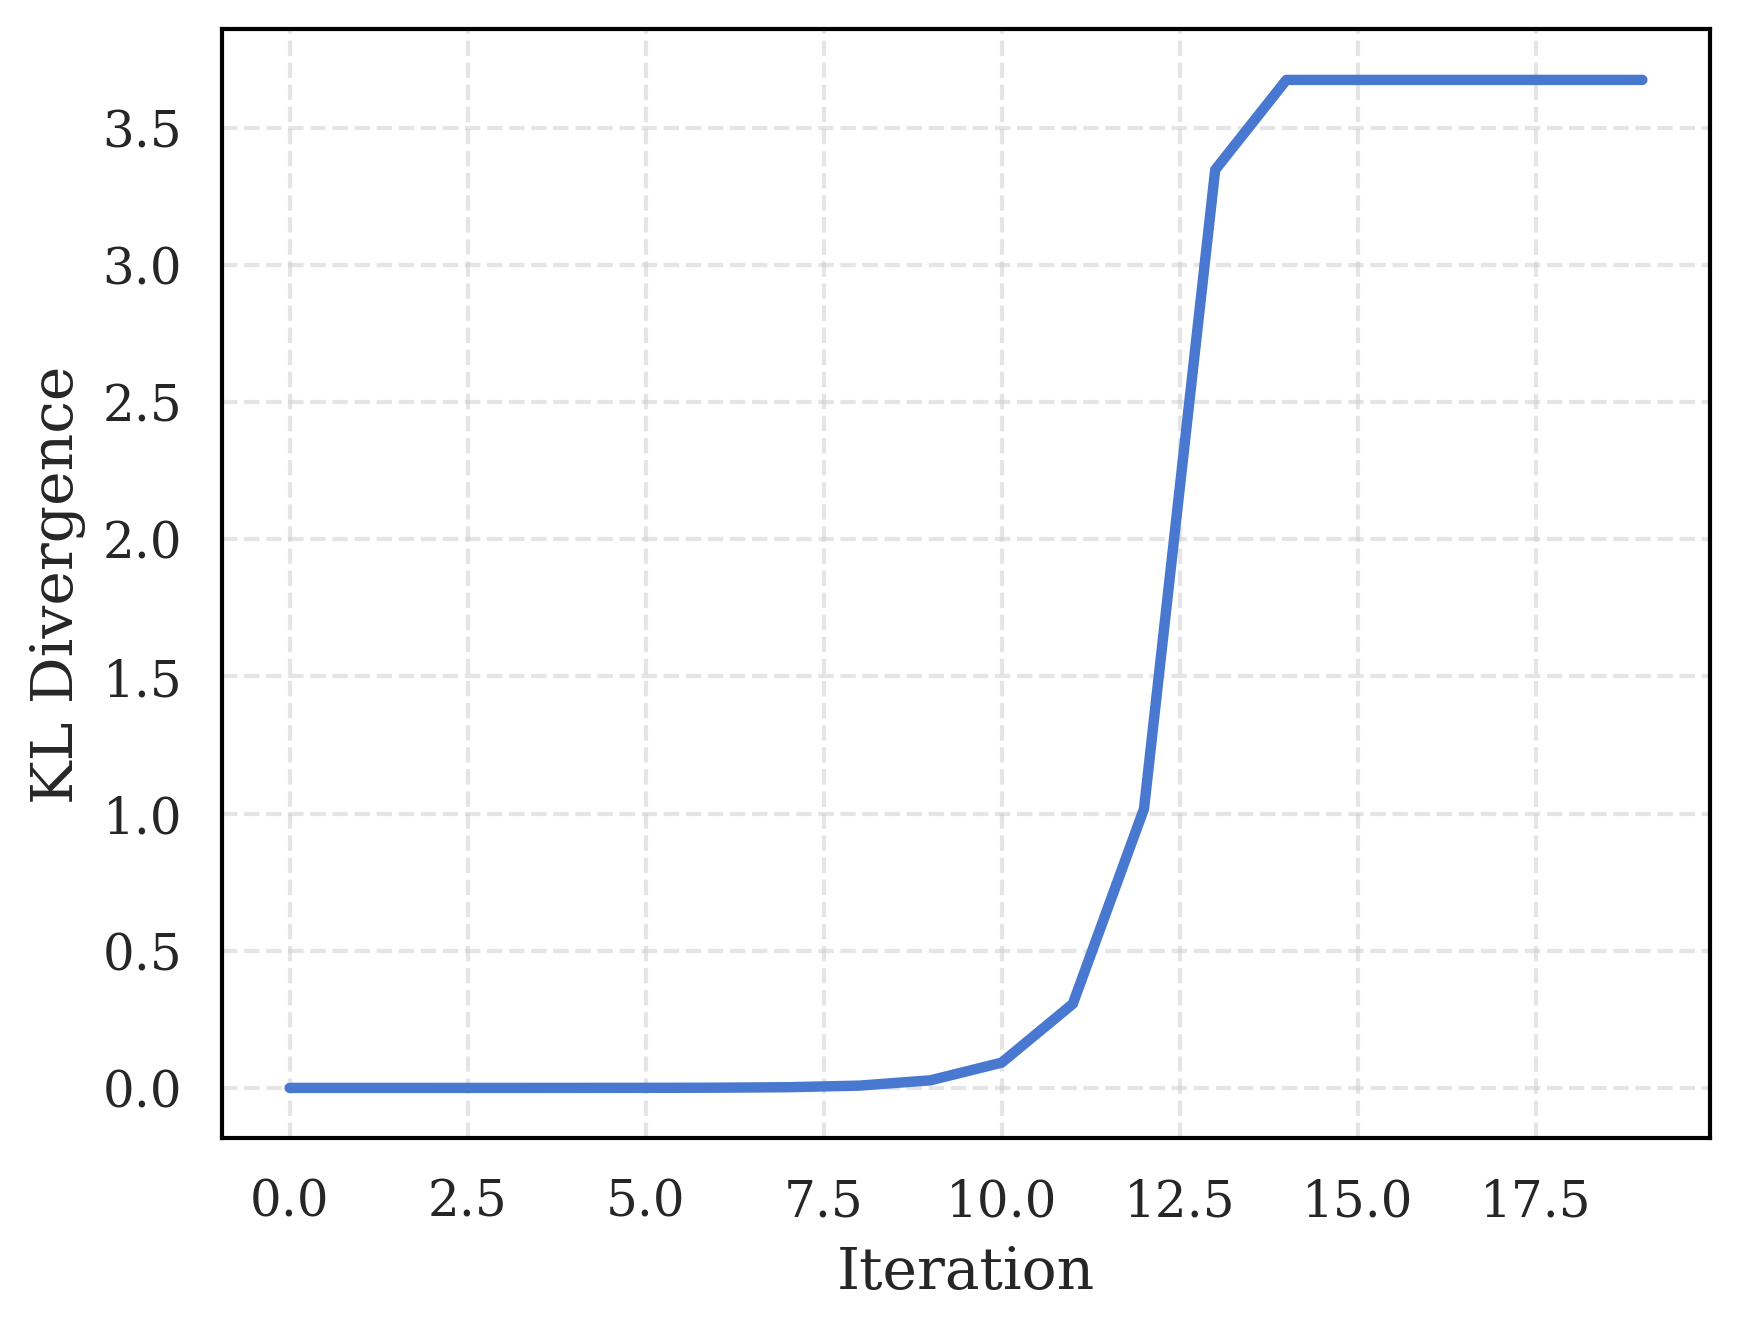

In [8]:
plt.plot(kl_values[:20])
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')

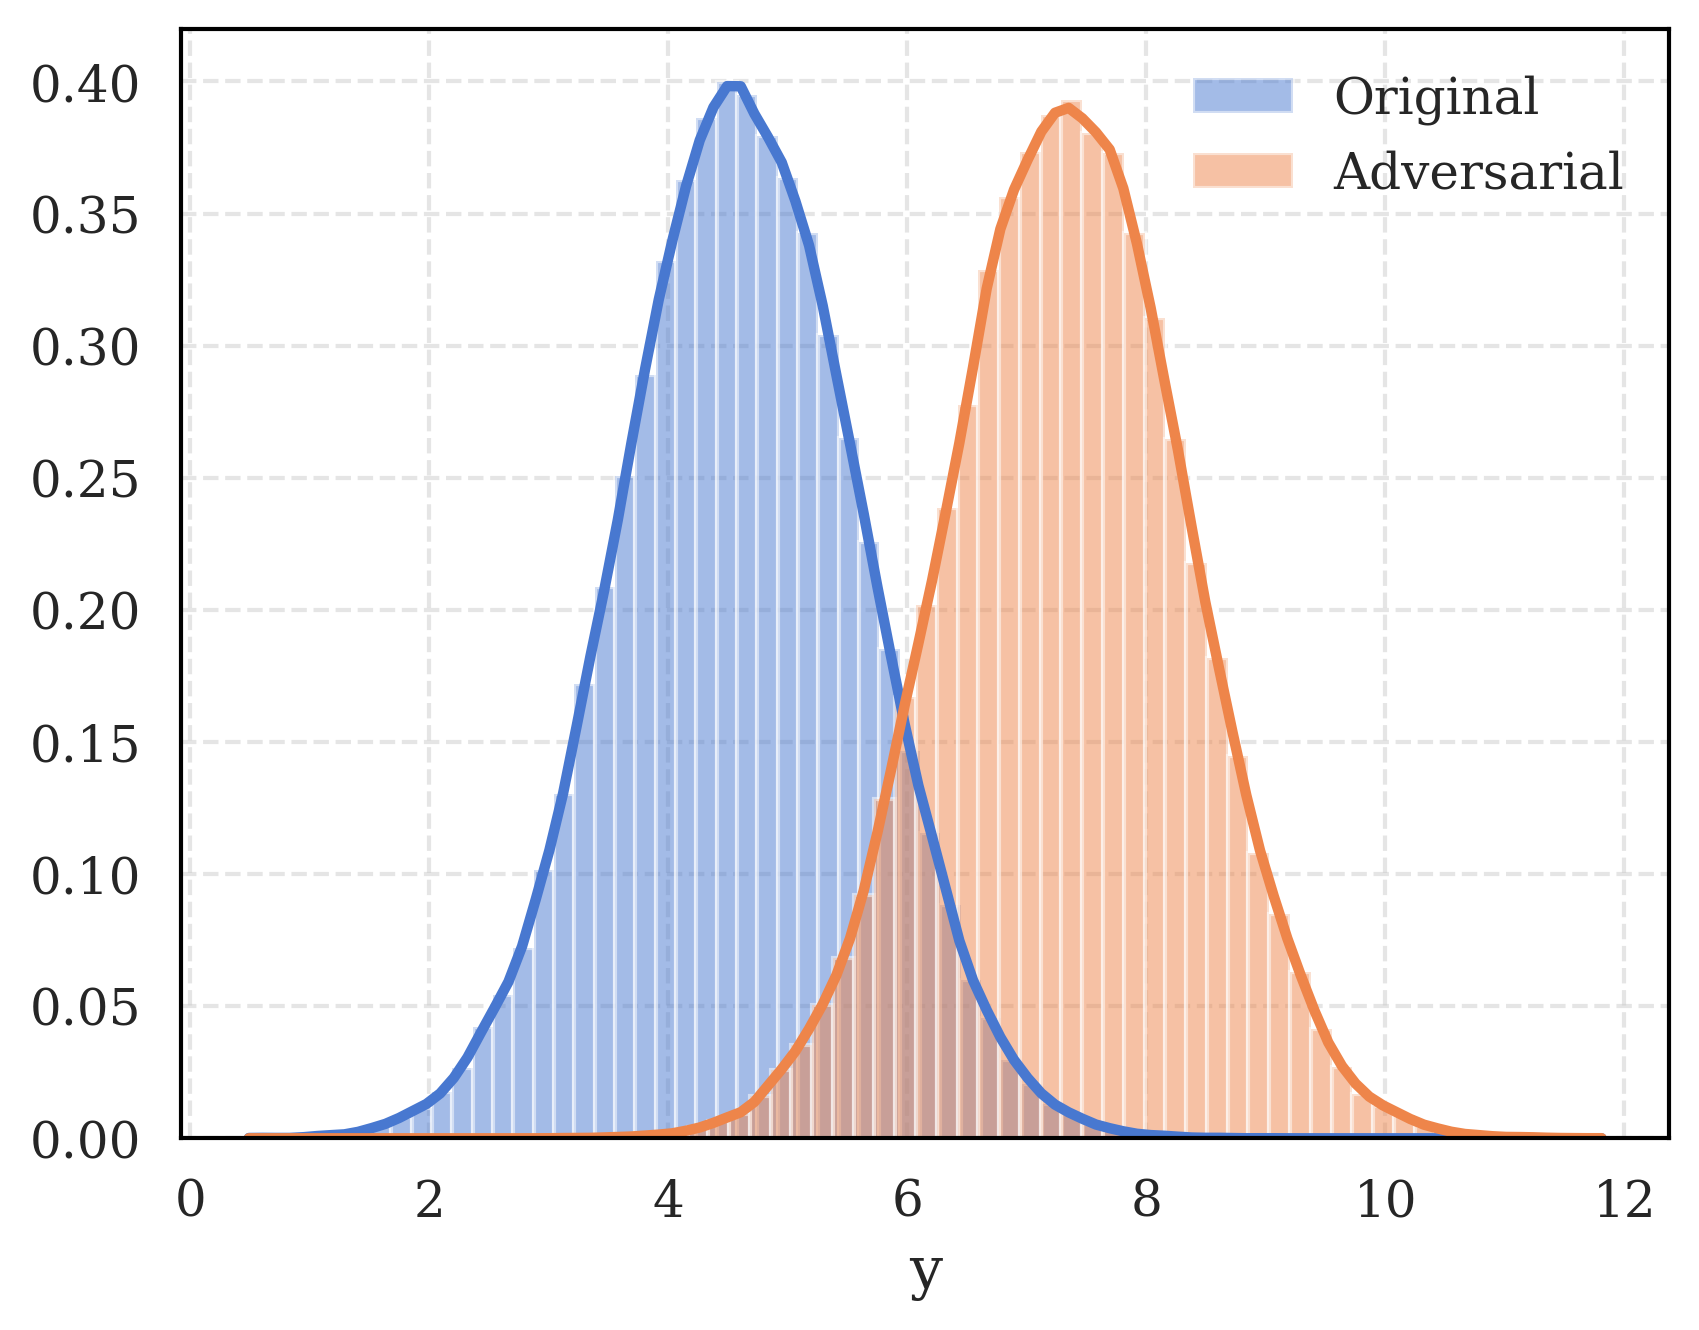

In [9]:
plot_ppds(model, x, x_adv_distr)

<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2690304/2771096520.py:16: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


Text(0, 0.5, 'KL Divergence')

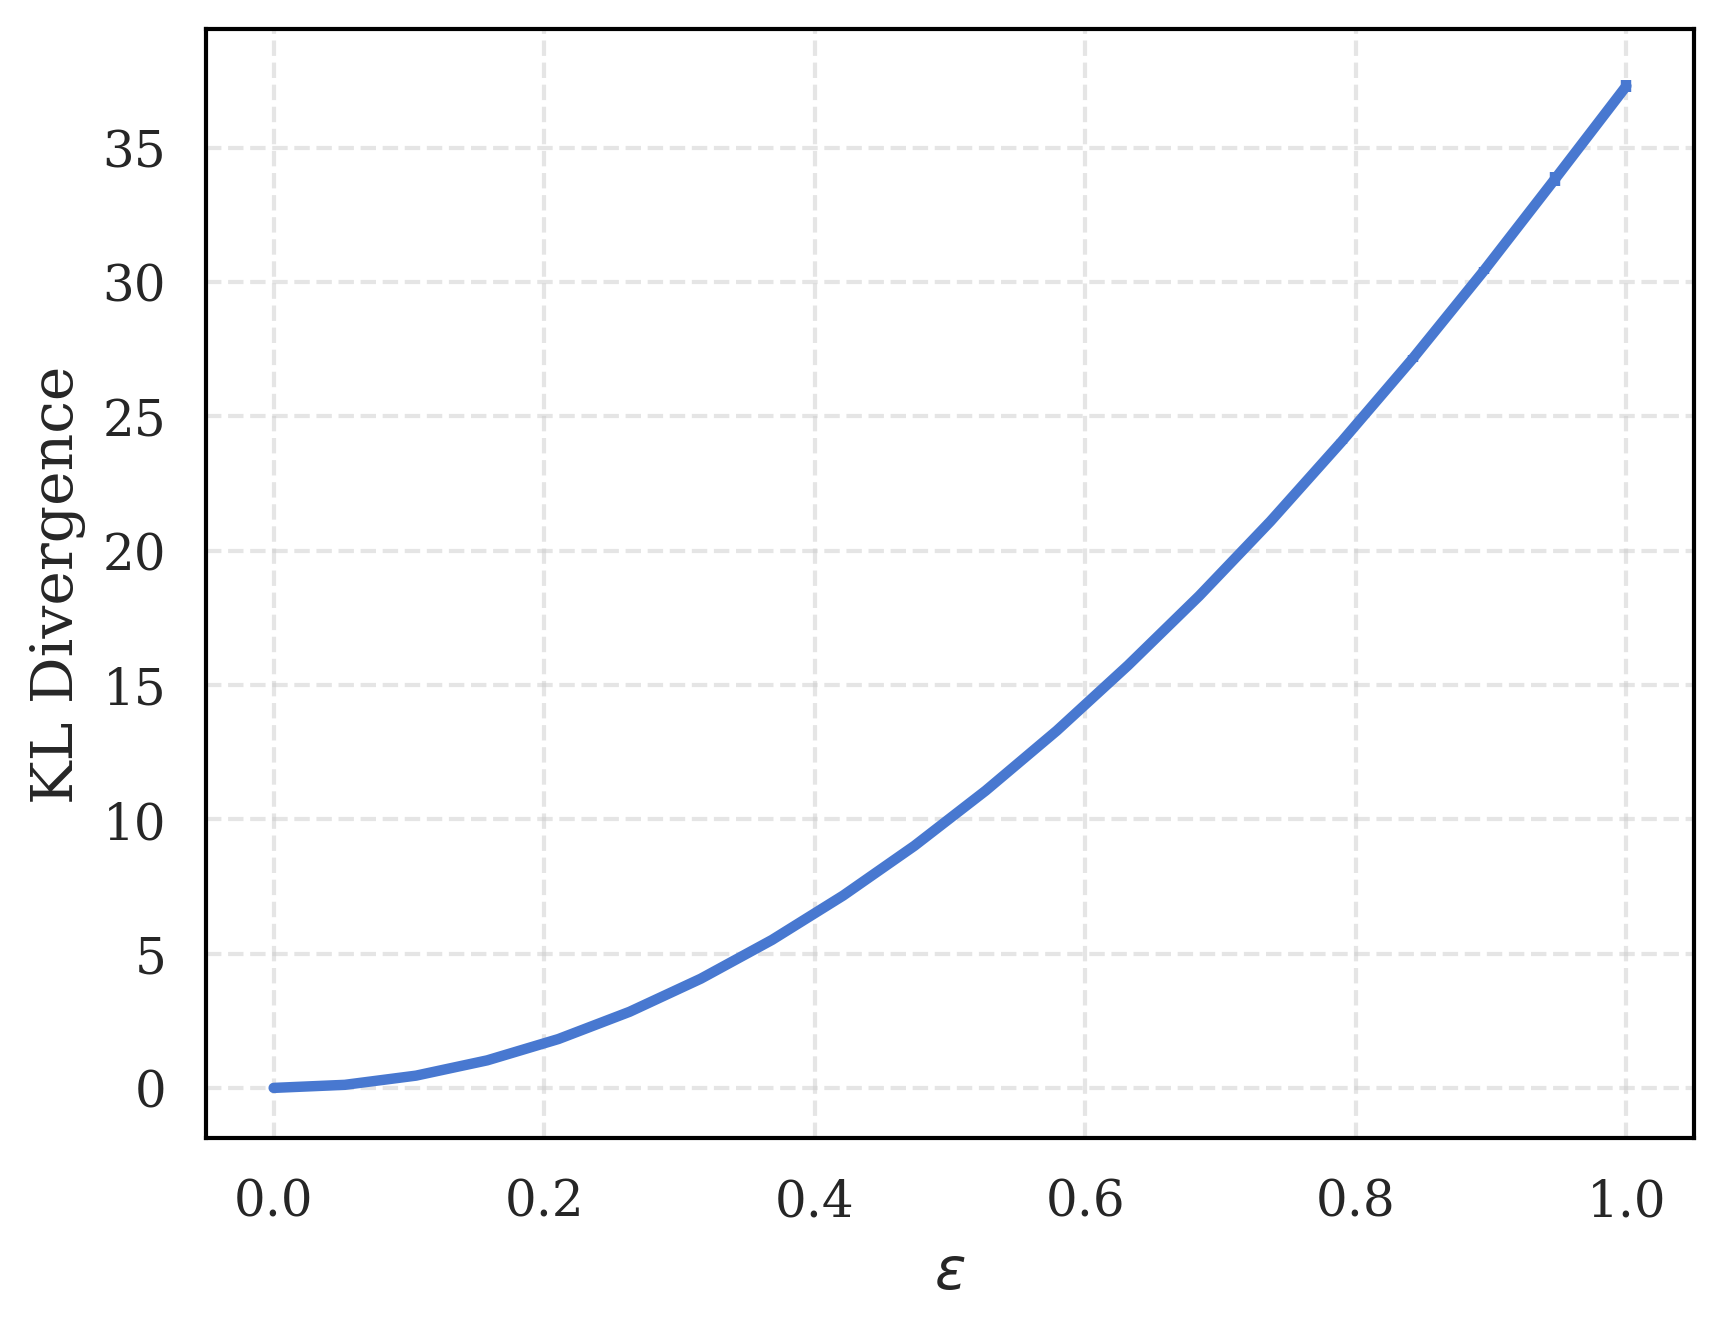

In [10]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

kl_alls = []
epsilons = np.linspace(0, 1, 20)

for _ in range(10):
    kl_values = []
    for epsilon in epsilons:
        x_adv_distr, _, kl = kl_maximization(model, x, epsilon=epsilon)
        kl_values.append(kl[-1])
    kl_alls.append(kl_values)

# std as error bars
plt.errorbar(epsilons, np.mean(kl_alls, axis=0), yerr=2*np.std(kl_alls, axis=0))
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')

## Case 2: SGD attack

### Case 2a: NormalInverseGamma model

In [11]:
# Fit the model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([10]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

/home/pgarcia/AdvReg/src/models/conjugate_bayes_lin_reg.py:119: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724788957849/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  b_n = self.b + 0.5 * (y.T @ y + self.mu.T @ self.lam @ self.mu - mu_n.T @ lam_n @ mu_n)


#### appd = N(2mu, 2var)

Early stopping at iteration 202


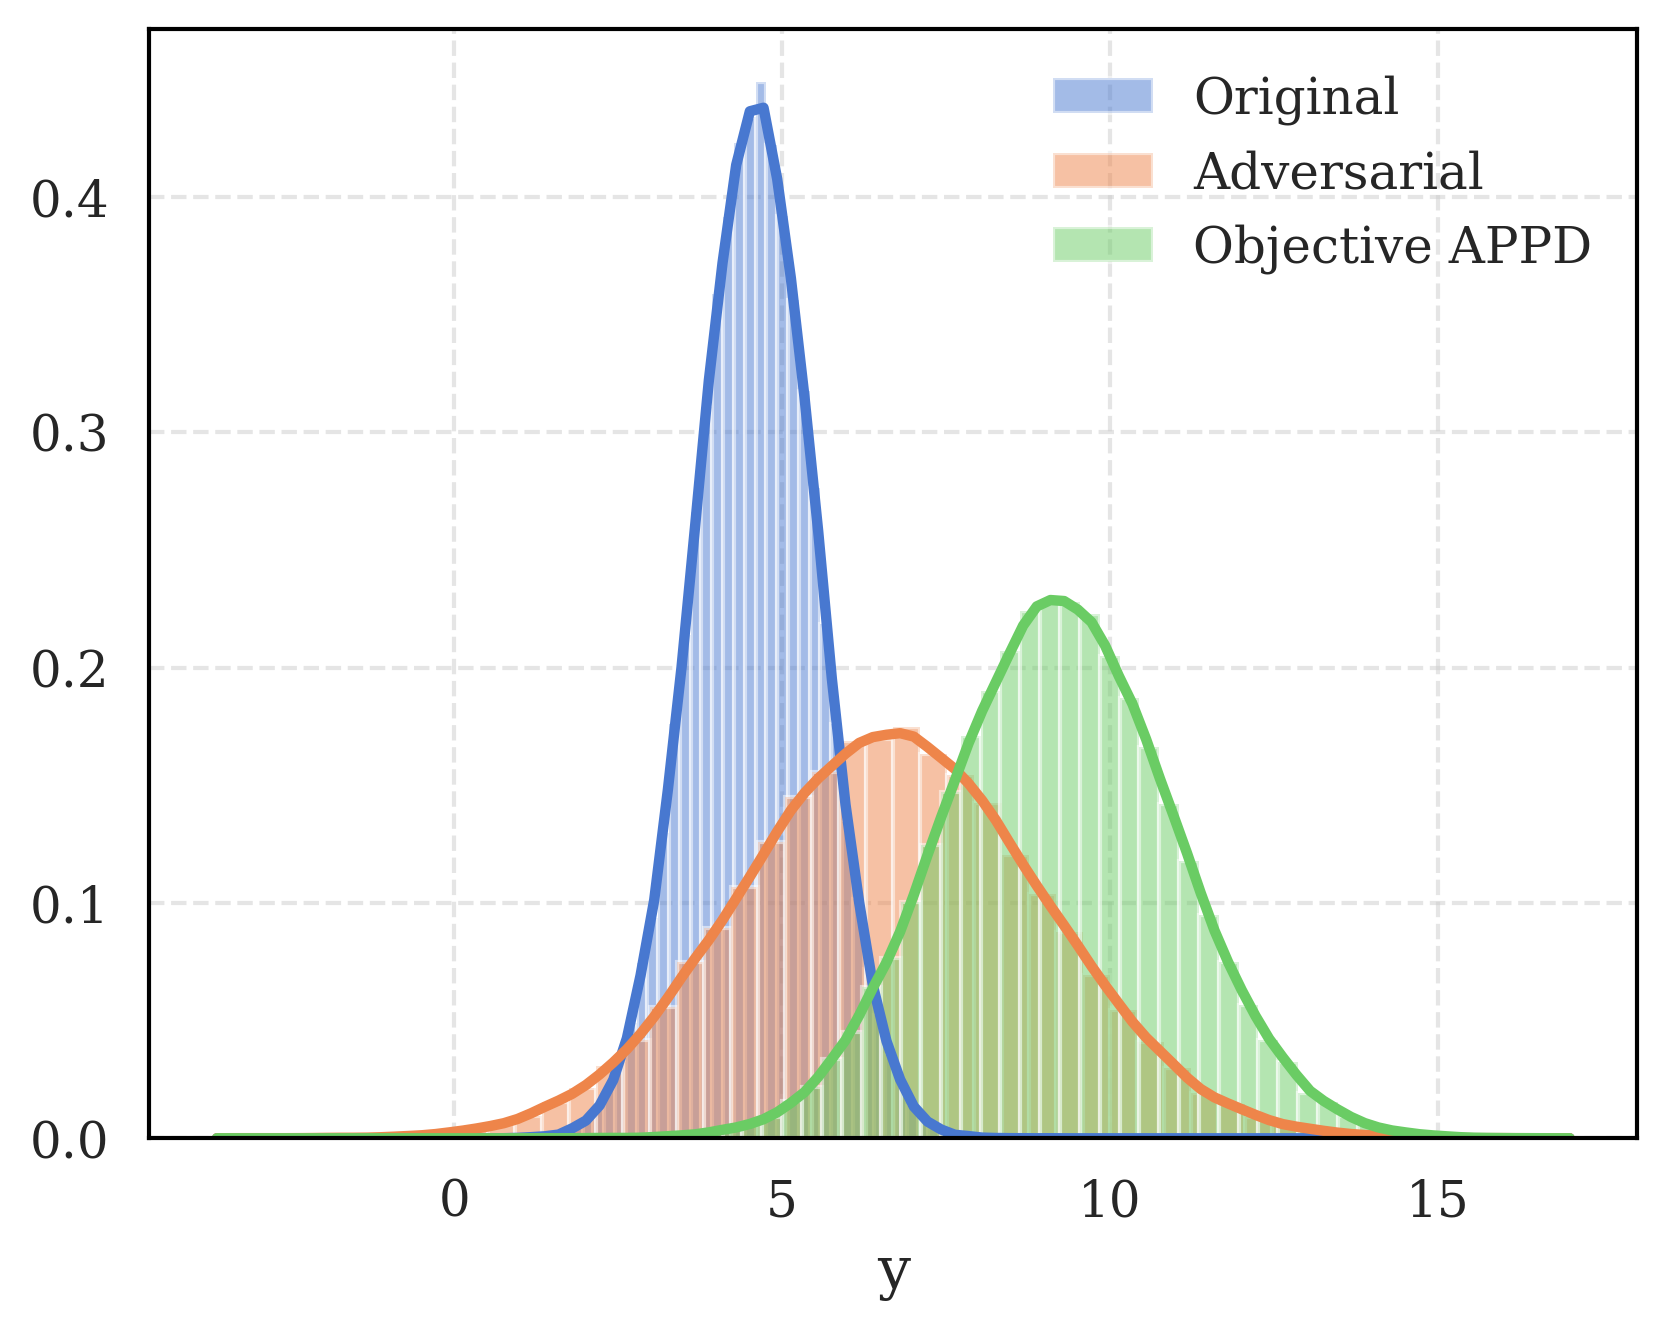

In [12]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 1000).std()
appd = torch.distributions.normal.Normal(2 * x.T @ model.mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=10, lr=0.1, n_iter=400)
plot_ppds(model, x, x_adv_distr, appd)

<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2690304/1166075015.py:35: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


(-0.1, 12.415961837768554)

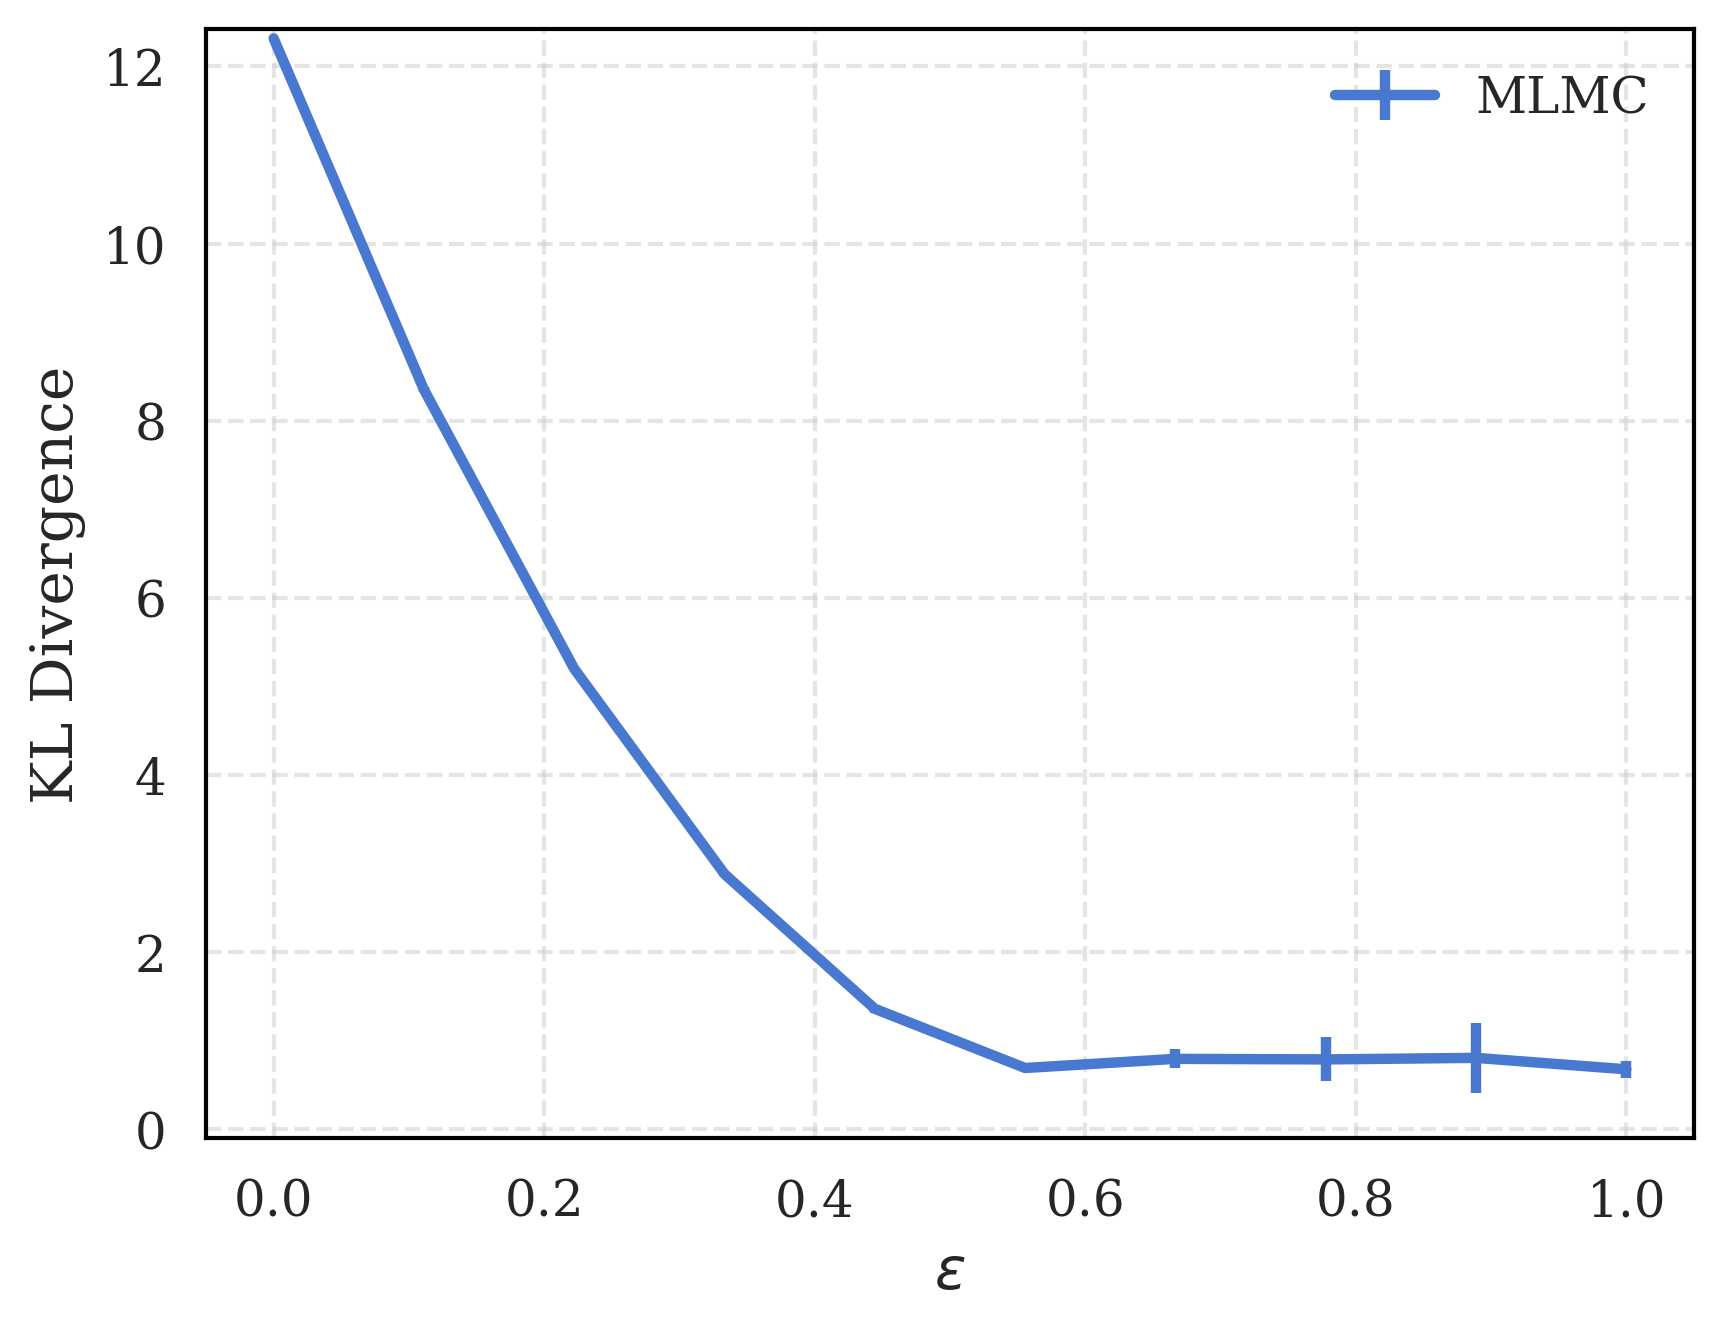

In [13]:
# plot KL divergence as a function of the strength of the attack
n_jobs = -1
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
std = model.sample_predictive_distribution(x, 1000).std()
appd = torch.distributions.normal.Normal(2 * x.T @ model.mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=epsilon, R=10, lr=0.01, n_iter=300, verbose=False)
    kl = kl_to_appd(model.mu, model.lam, sigma2, x_adv_distr, 2 * x.T @ model.mu, 4 * std ** 2).item()
    x_fgsm = fgsm_attack(model, x, epsilon=epsilon, R=100)
    kl_fgsm = kl_to_appd(model.mu, model.lam, sigma2, x_fgsm, 2 * x.T @ model.mu, 4 * std ** 2).item()
    return kl, kl_fgsm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 10)
kl_alls = []

for _ in range(5):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
#plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(-0.1, np.max(kl_mlmc) + 0.1)

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2690304/2116026025.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


(-0.1, 12.415961837768554)

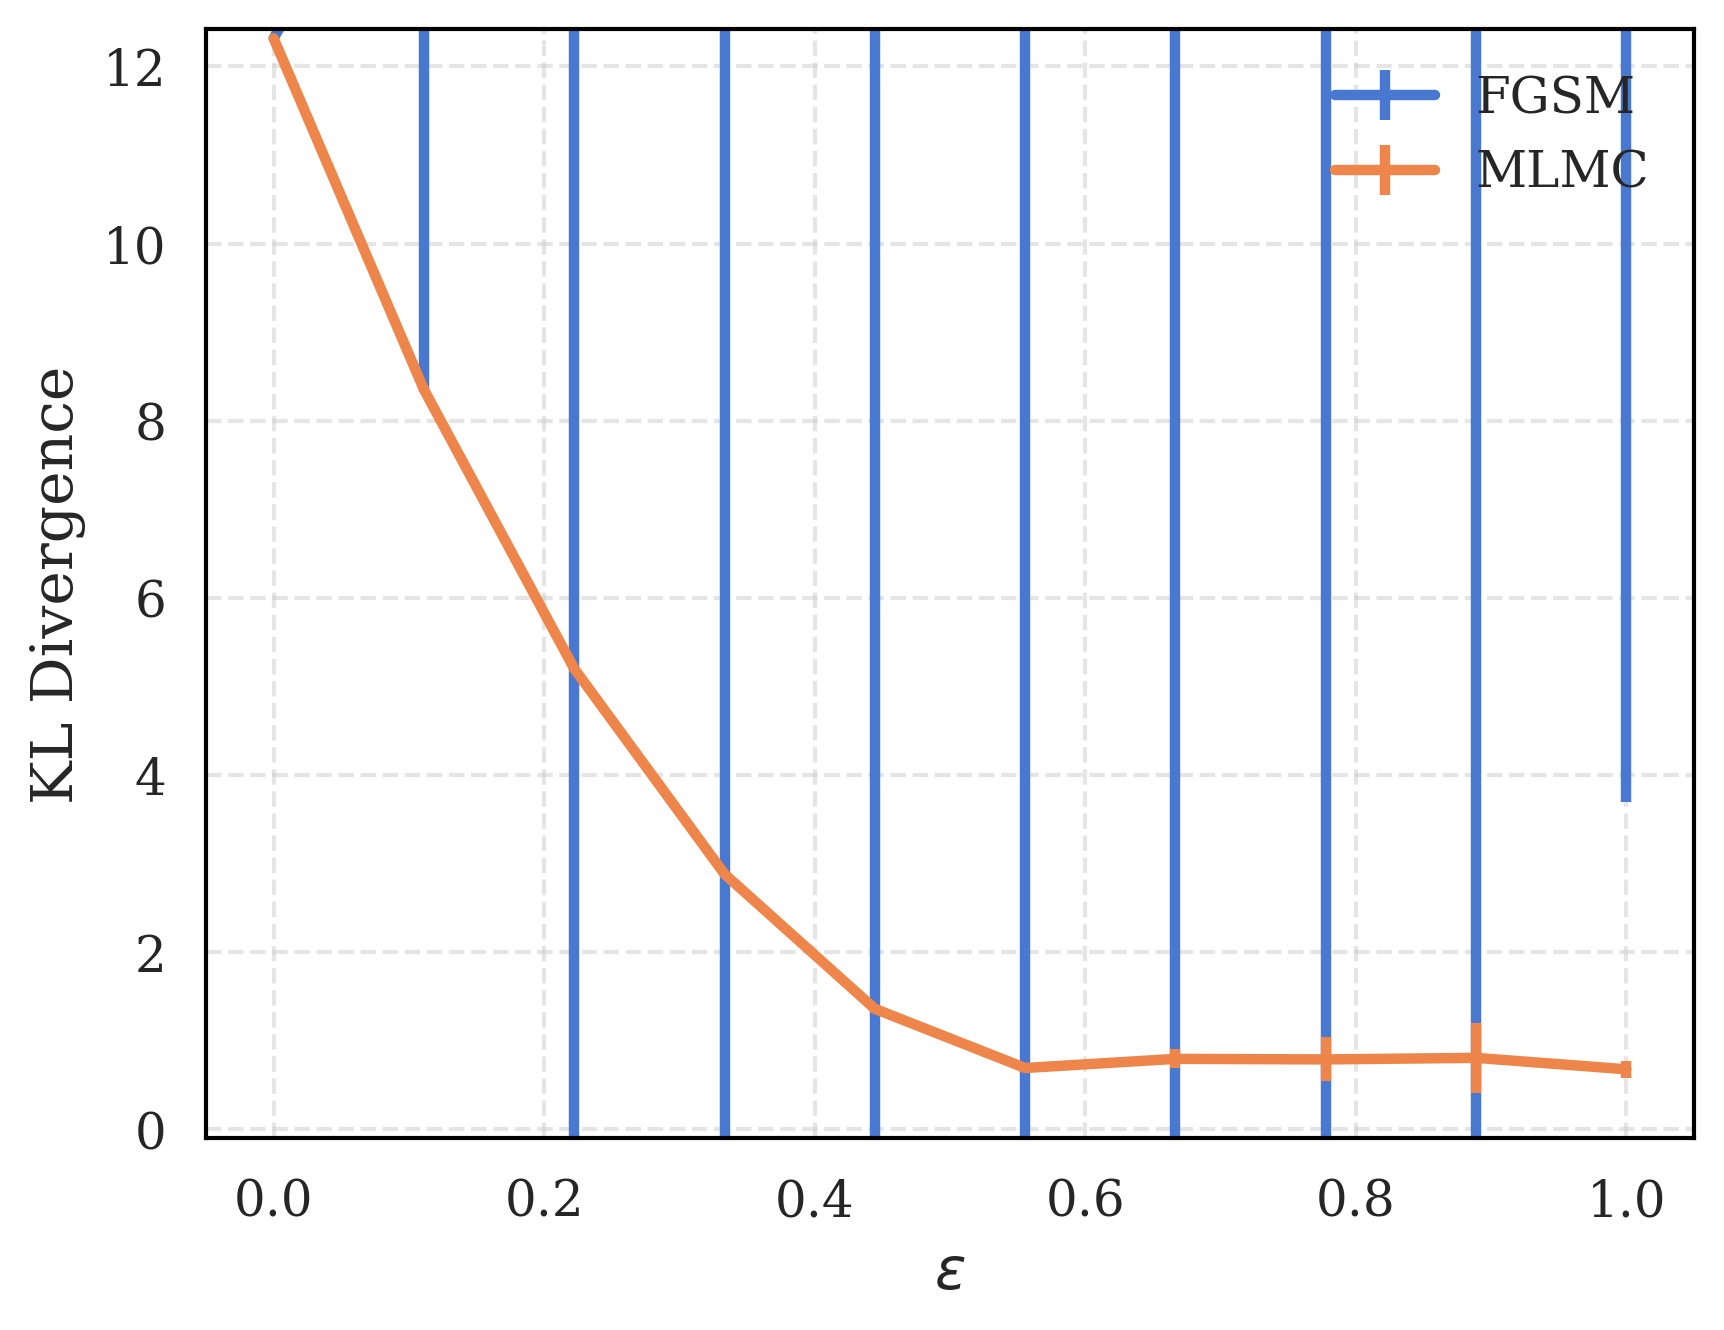

In [14]:
plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(-0.1, np.max(kl_mlmc) + 0.1)

#### appd = N(mu, 2var)

Early stopping at iteration 183


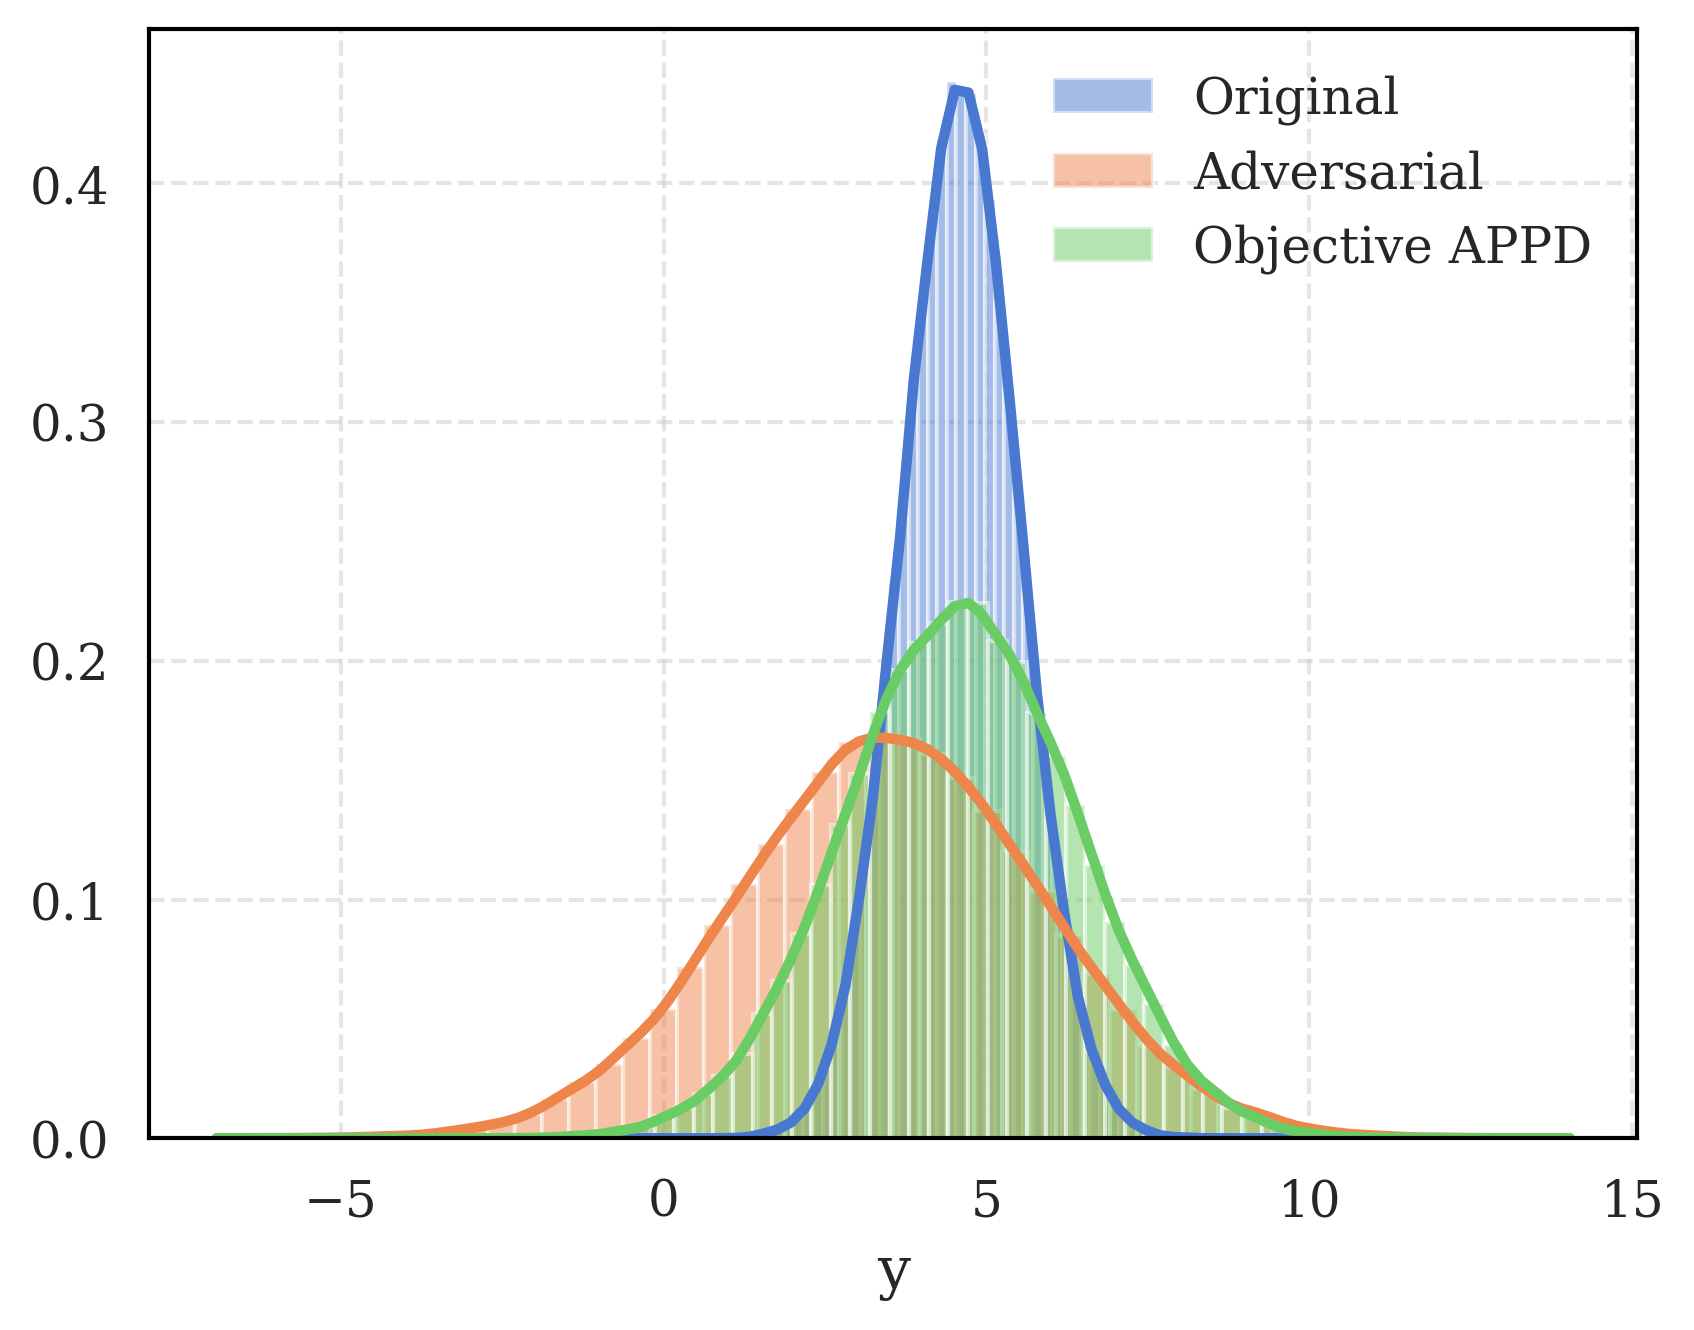

In [15]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 1000).std()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=10, lr=0.1, n_iter=400)
plot_ppds(model, x, x_adv_distr, appd)

<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2690304/3702302221.py:35: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 28
Early stopping at iteration 12
Early stopping at iteration 182
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 130
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 41
Early stopping at iteration 12
Early stopping at iteration 23
Early stopping at iteration 220
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 49
Early stopping at iteration 253
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 24
Early stopping at iteration 185
Early stopping at iteration 20
Early stopping at iteration 24
Early stopping at iteration 12
Early stopping at iteration 74
Early stopping at iteration 12
Early stopping at iteration 15
Early stopping at iteration 73
Early stopping at iteration 293
Early stopping at iteration 12
Early stopping at iteration 12
Ea

(-0.1, 19.977161026000978)

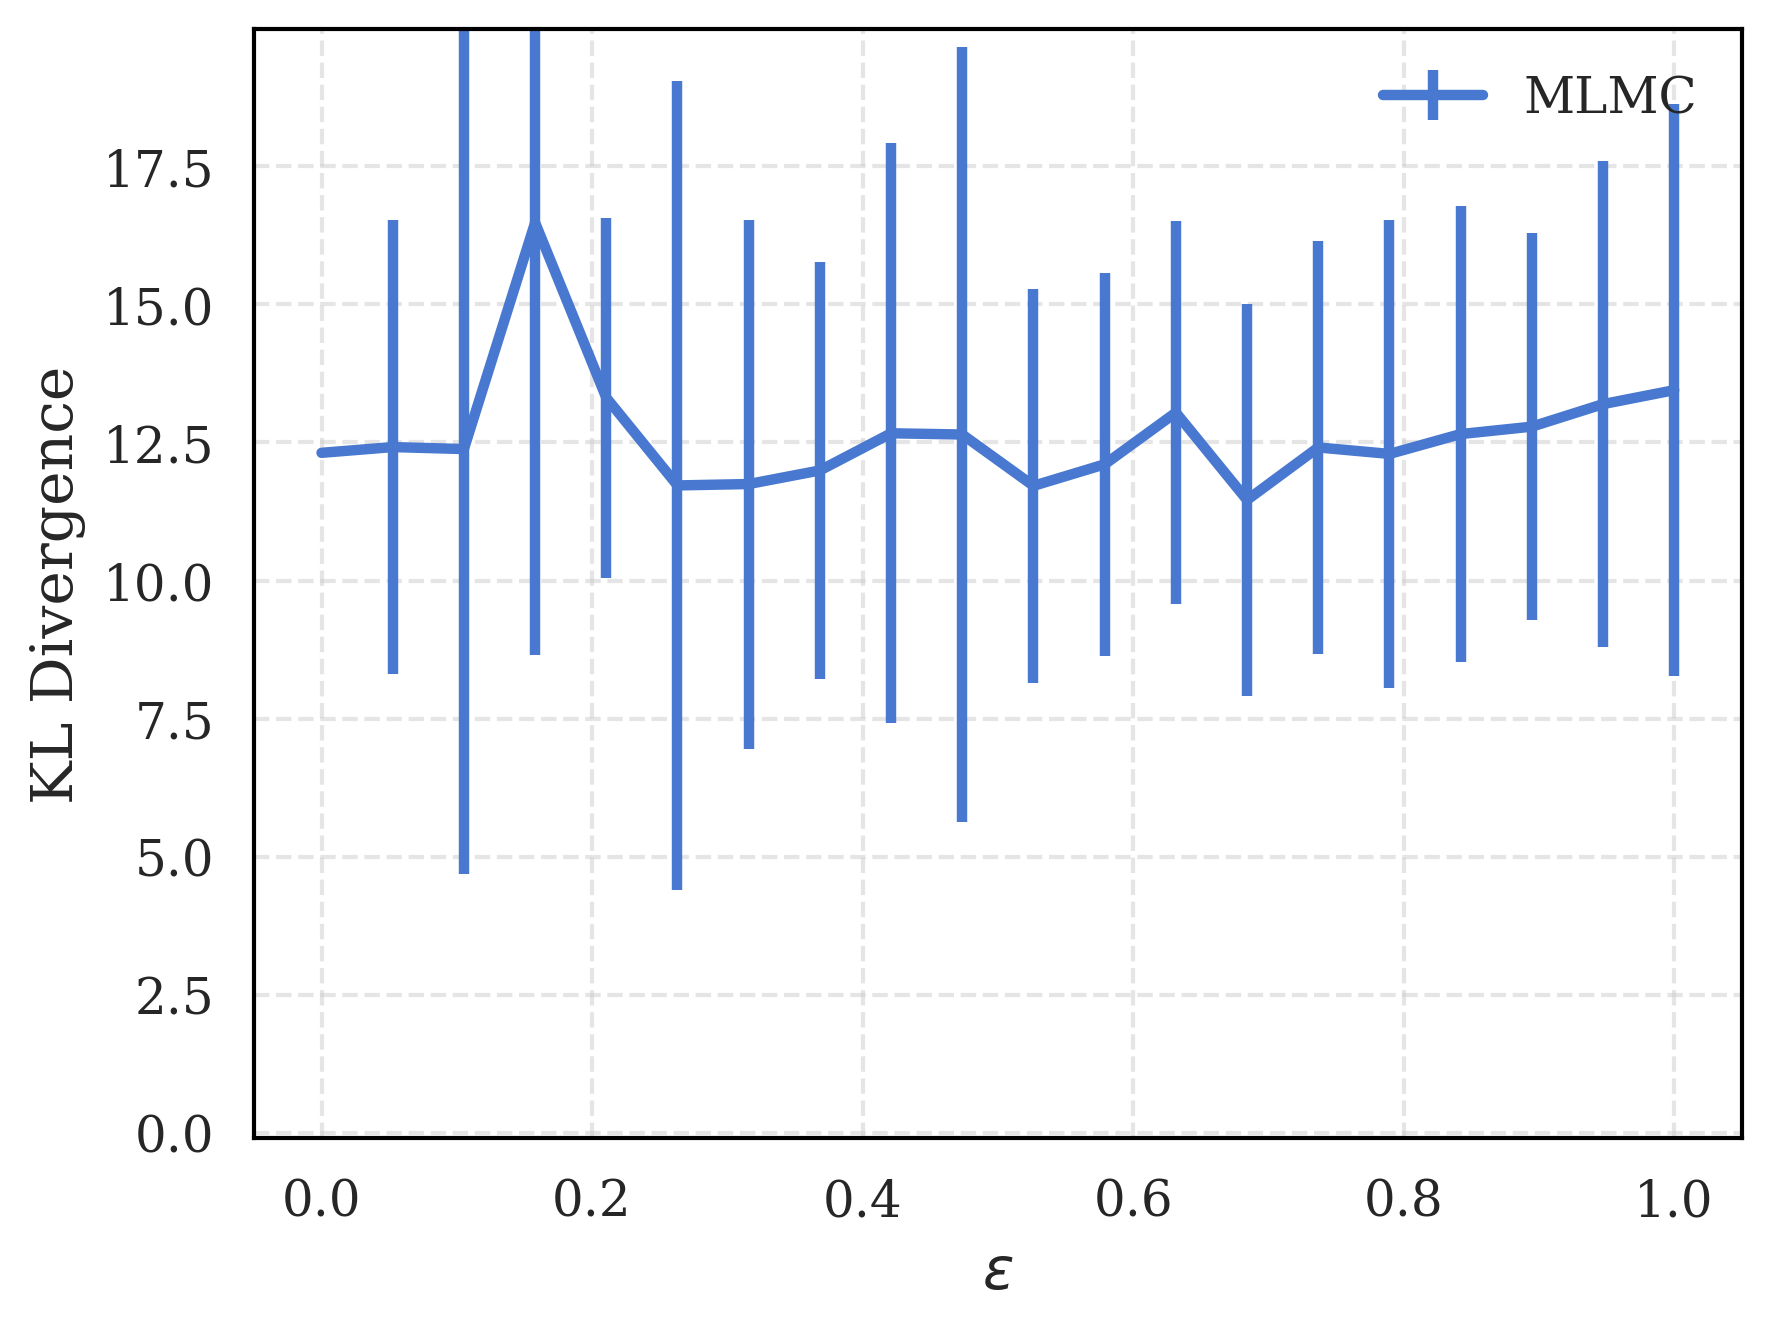

In [16]:
# plot KL divergence as a function of the strength of the attack
n_jobs = 66
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
std = model.sample_predictive_distribution(x, 1000).std()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=2*epsilon, R=10, lr=0.01, n_iter=300)
    kl = kl_to_appd(model.mu, model.lam, sigma2, x_adv_distr, 2 * x.T @ model.mu, 4 * std ** 2).item()
    x_fgsm = fgsm_attack(model, x, epsilon=epsilon, R=10)
    kl_fsgm = kl_to_appd(model.mu, model.lam, sigma2, x_fgsm, 2 * x.T @ model.mu, 4 * std ** 2).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
#plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(-0.1, np.max(kl_mlmc) + 0.1)

In [17]:
# plot KL divergence as a function of the strength of the attack WITH LR=0.01
n_jobs = 66
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
std = model.sample_predictive_distribution(x, 1000).std()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=epsilon, R=10, lr=0.001, n_iter=400)
    kl = kl_to_appd(model.mu, model.lam, sigma2, x_adv_distr, 2 * x.T @ model.mu, 4 * std ** 2).item()
    x_fgsm = fgsm_attack(model, x, epsilon=epsilon, R=10)
    kl_fsgm = kl_to_appd(model.mu, model.lam, sigma2, x_fgsm, 2 * x.T @ model.mu, 4 * std ** 2).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
#plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(-0.1, np.max(kl_mlmc) + 0.1)

<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2690304/2737558167.py:35: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 81
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 315
Early stopping at iteration 12
Early stopping at iteration 135


In [ ]:
plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(-0.1, np.max(kl_mlmc) + 0.1)

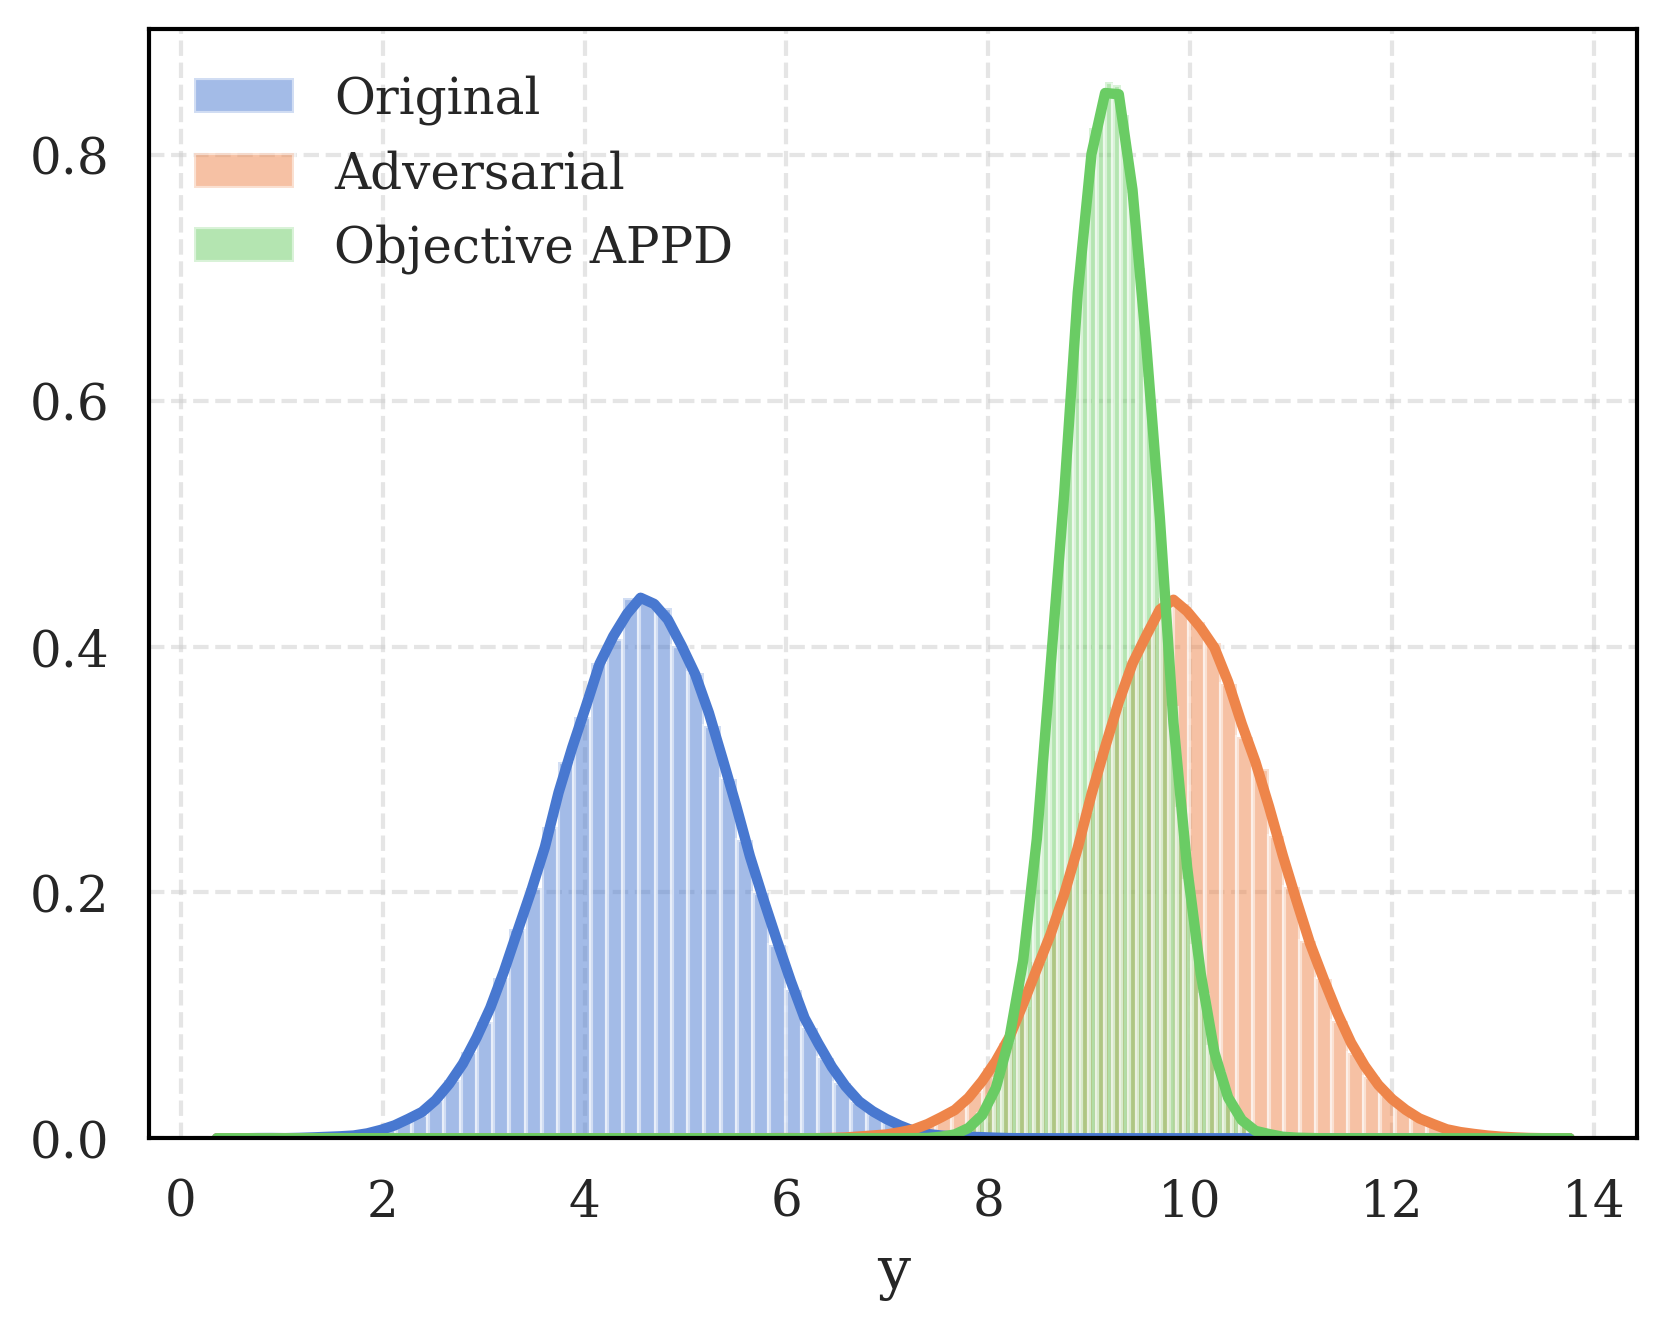

In [18]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 1000).std()
appd = torch.distributions.normal.Normal(2 * x.T @ model.mu, 0.5 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=5, R=10, lr=0.1, n_iter=400)
plot_ppds(model, x, x_adv_distr, appd)

### Case 2b: Same model as case 1

In [19]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

Early stopping at iteration 256


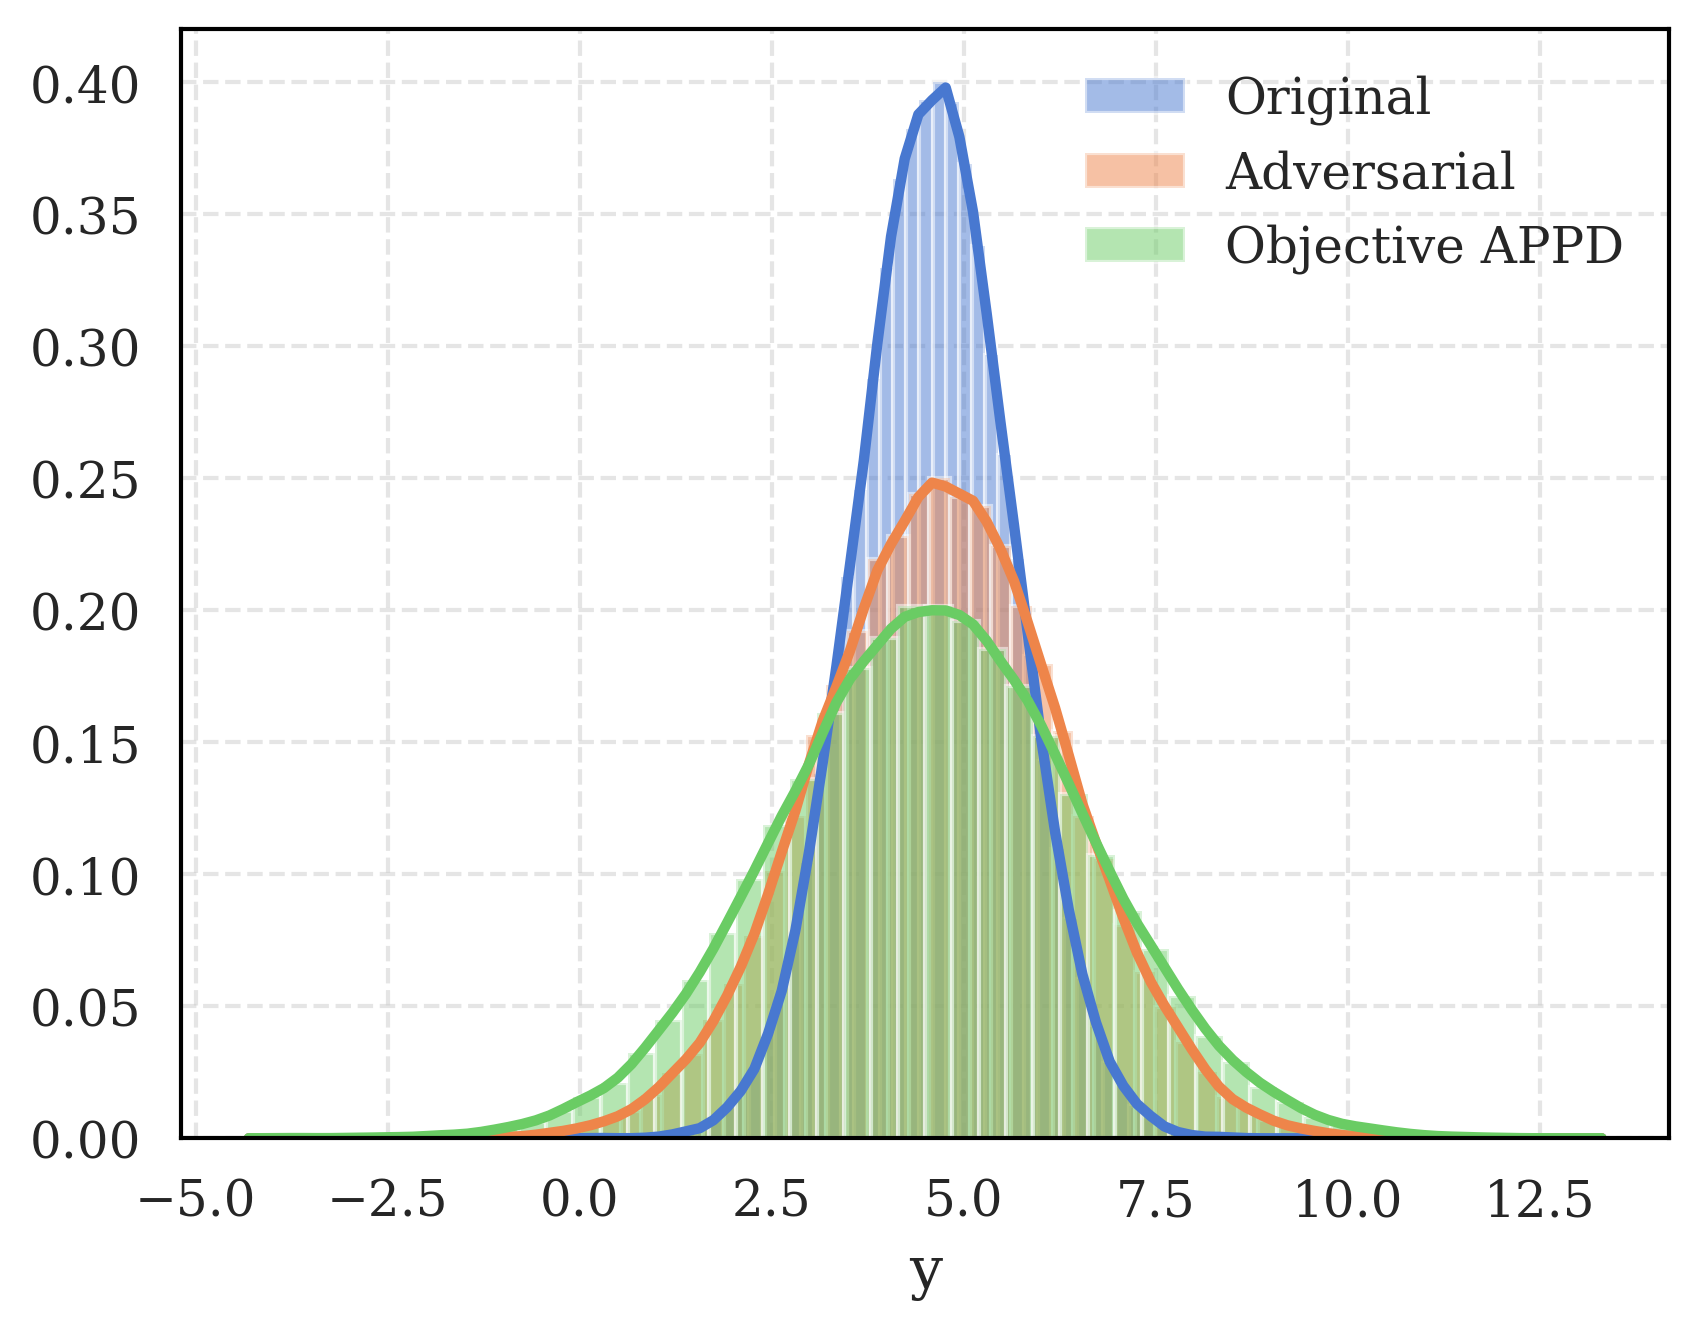

In [20]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 1000).std()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, lr=.1, R=10, n_iter=400)
plot_ppds(model, x, x_adv_distr, appd)

Early stopping at iteration 144


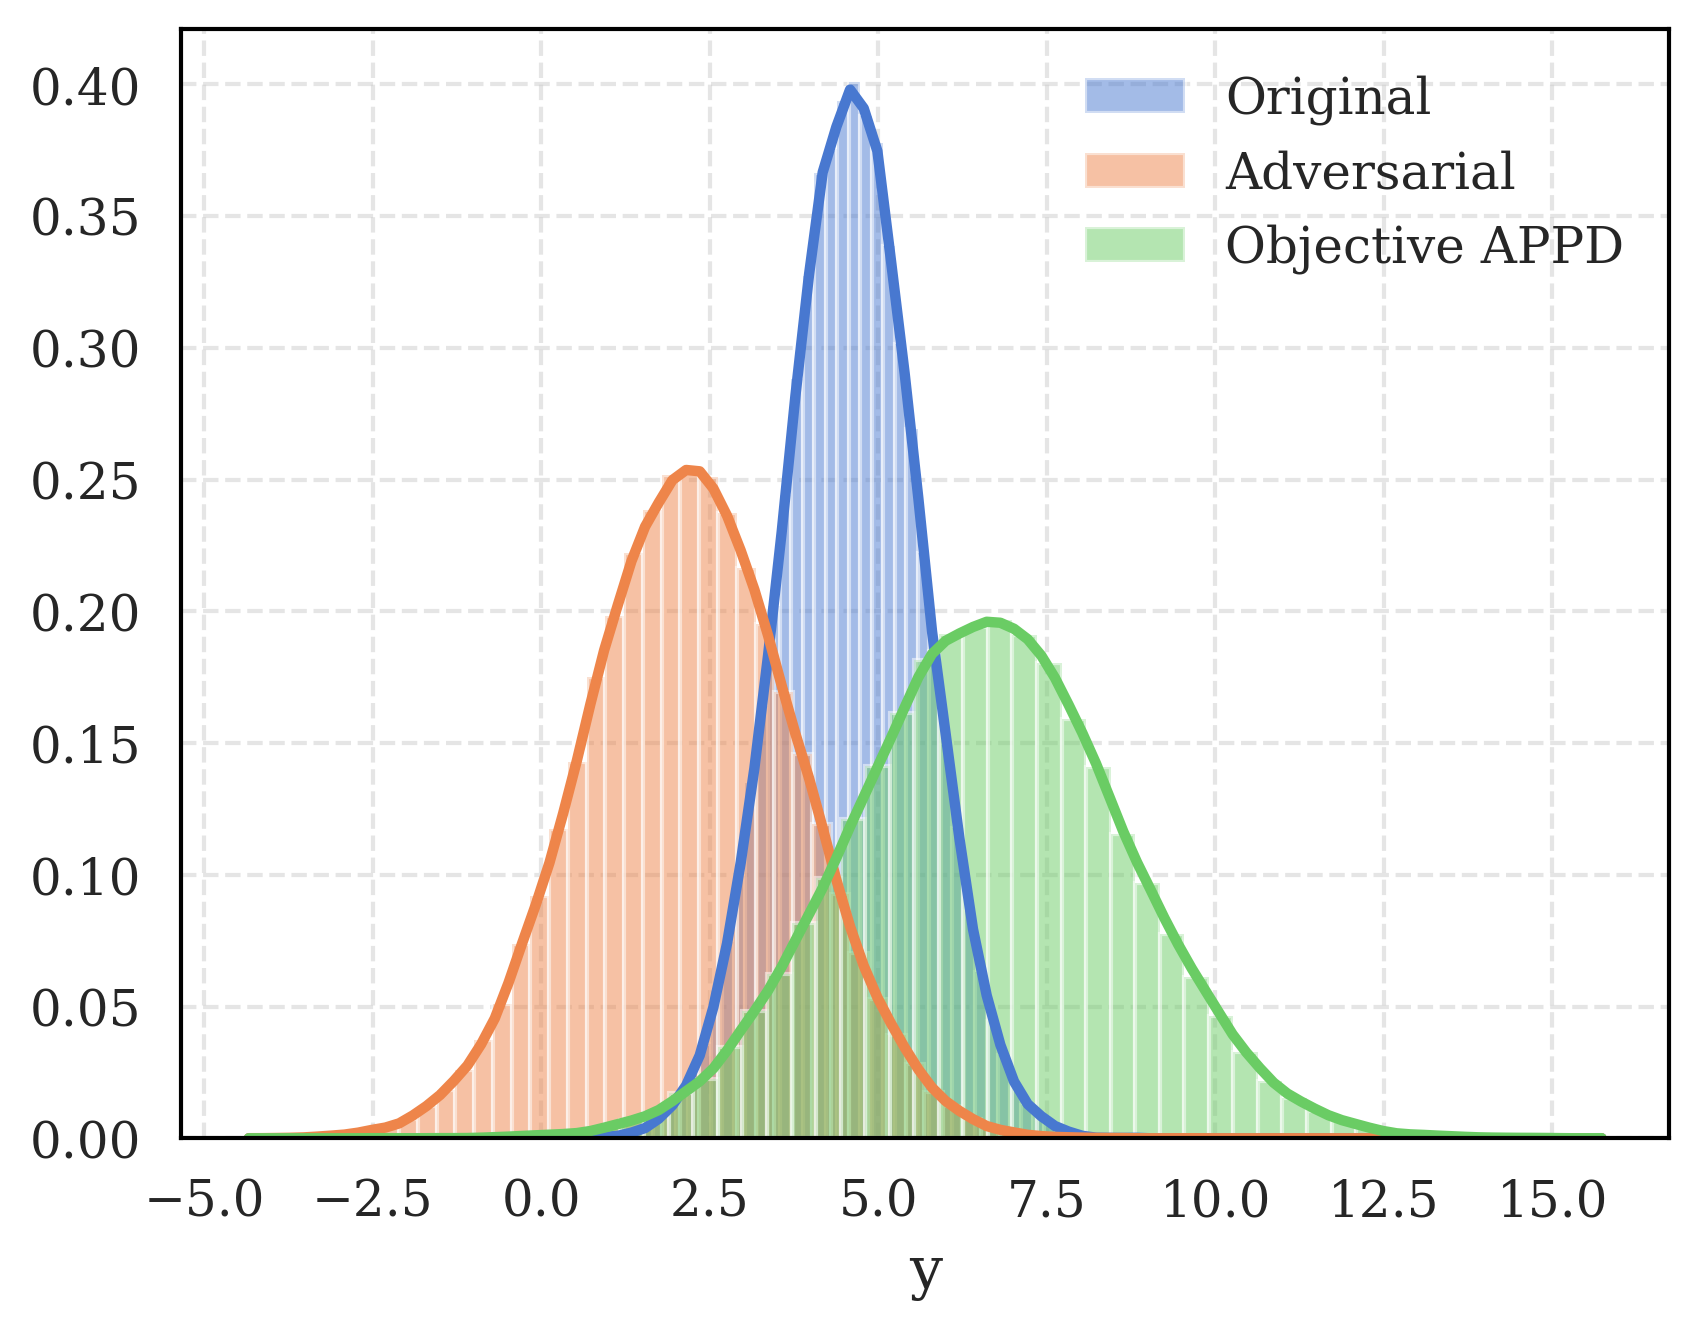

In [21]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 1000).std()
appd = torch.distributions.normal.Normal(2 + x.T @ model.mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, lr=.1, R=10, n_iter=400)
plot_ppds(model, x, x_adv_distr, appd)

## Maximum disruption problem

In [22]:
# Normal Inverse Gamma Model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([10]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

Early stopping at iteration 27


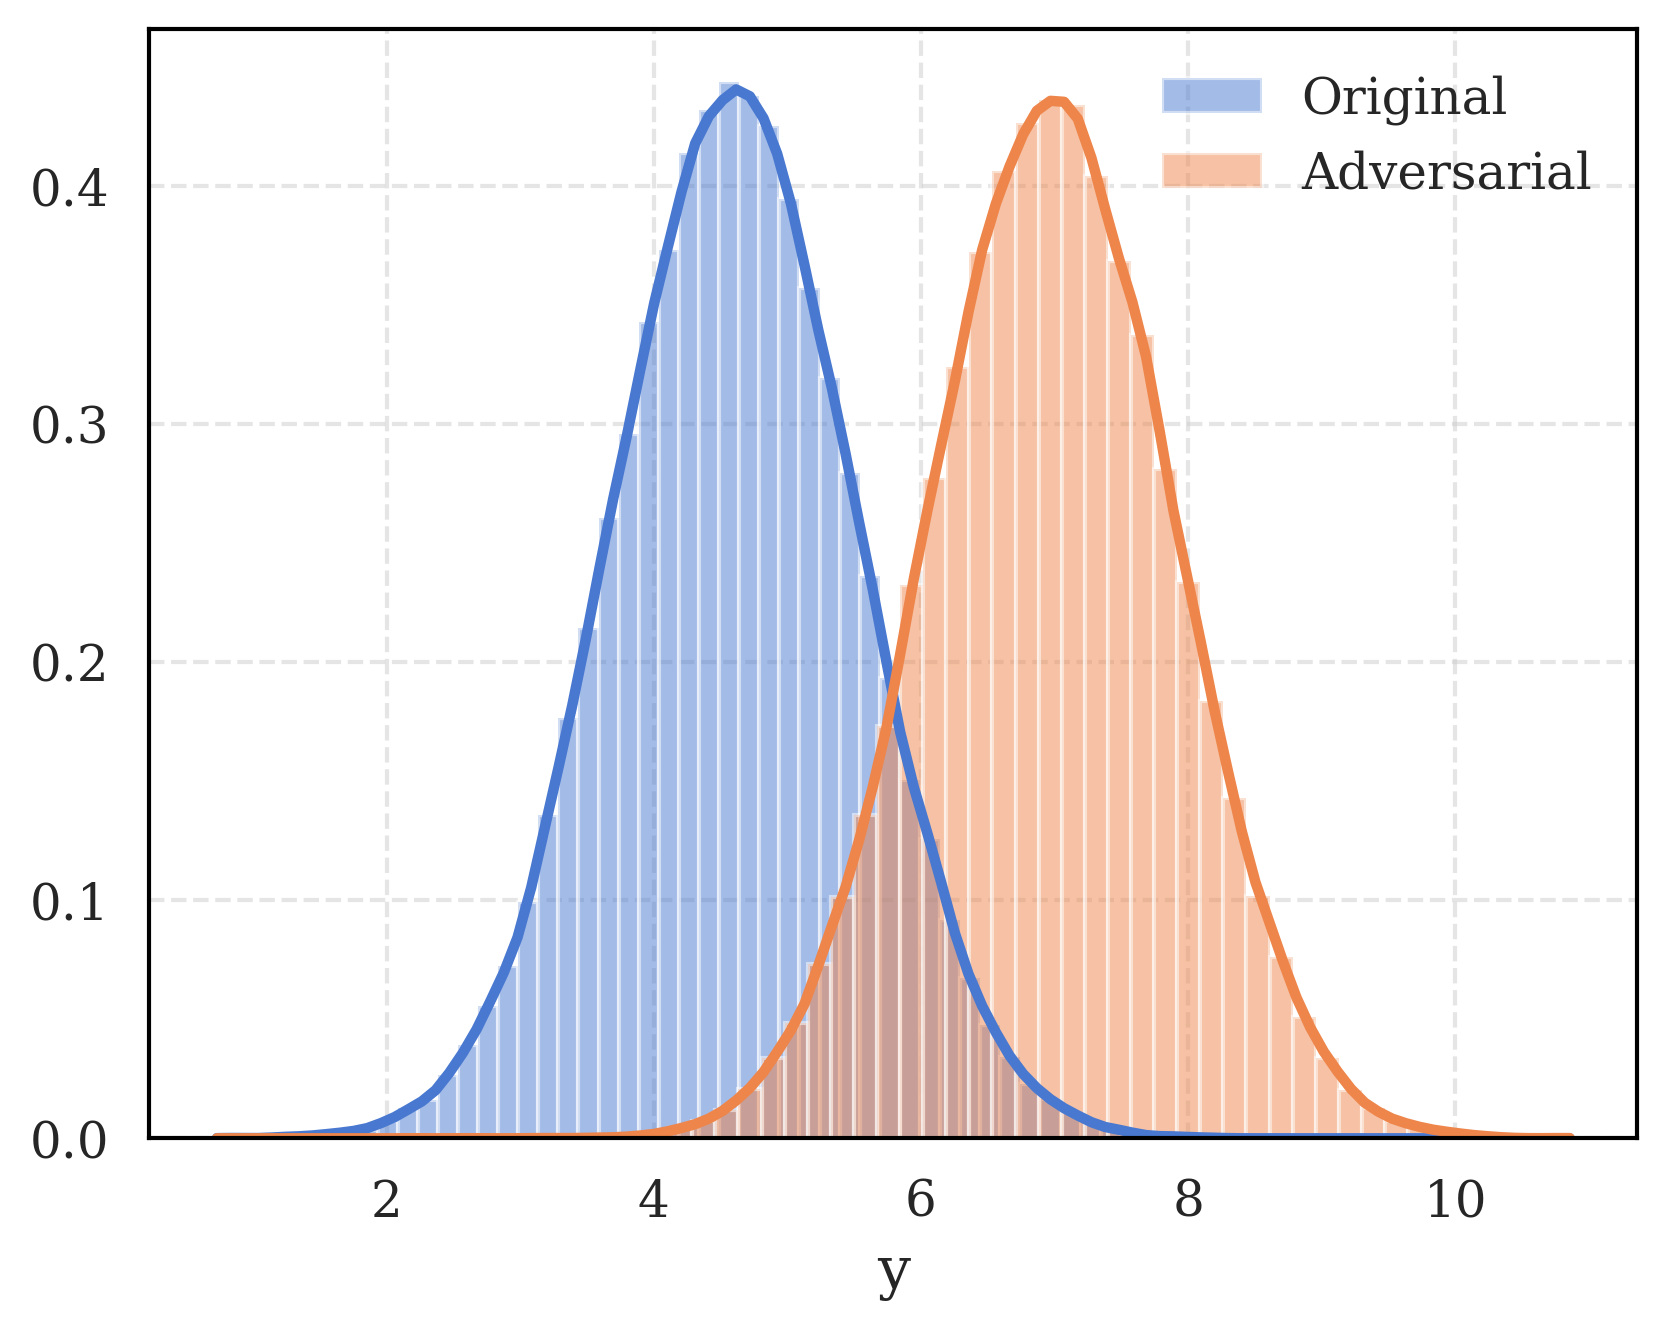

In [23]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values = mlmc_attack(model, x, epsilon=.3, R=100, lr=0.01, n_iter=200)
plot_ppds(model, x, x_adv_distr)

<>:26: SyntaxWarning: invalid escape sequence '\e'
<>:26: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2657876/737261988.py:26: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title(f'$\epsilon=${epsilon:.2f}')


Early stopping at iteration 14
Early stopping at iteration 24
Early stopping at iteration 21
Early stopping at iteration 21
Early stopping at iteration 35
Early stopping at iteration 32
Early stopping at iteration 31
Early stopping at iteration 47
Early stopping at iteration 43
Early stopping at iteration 48


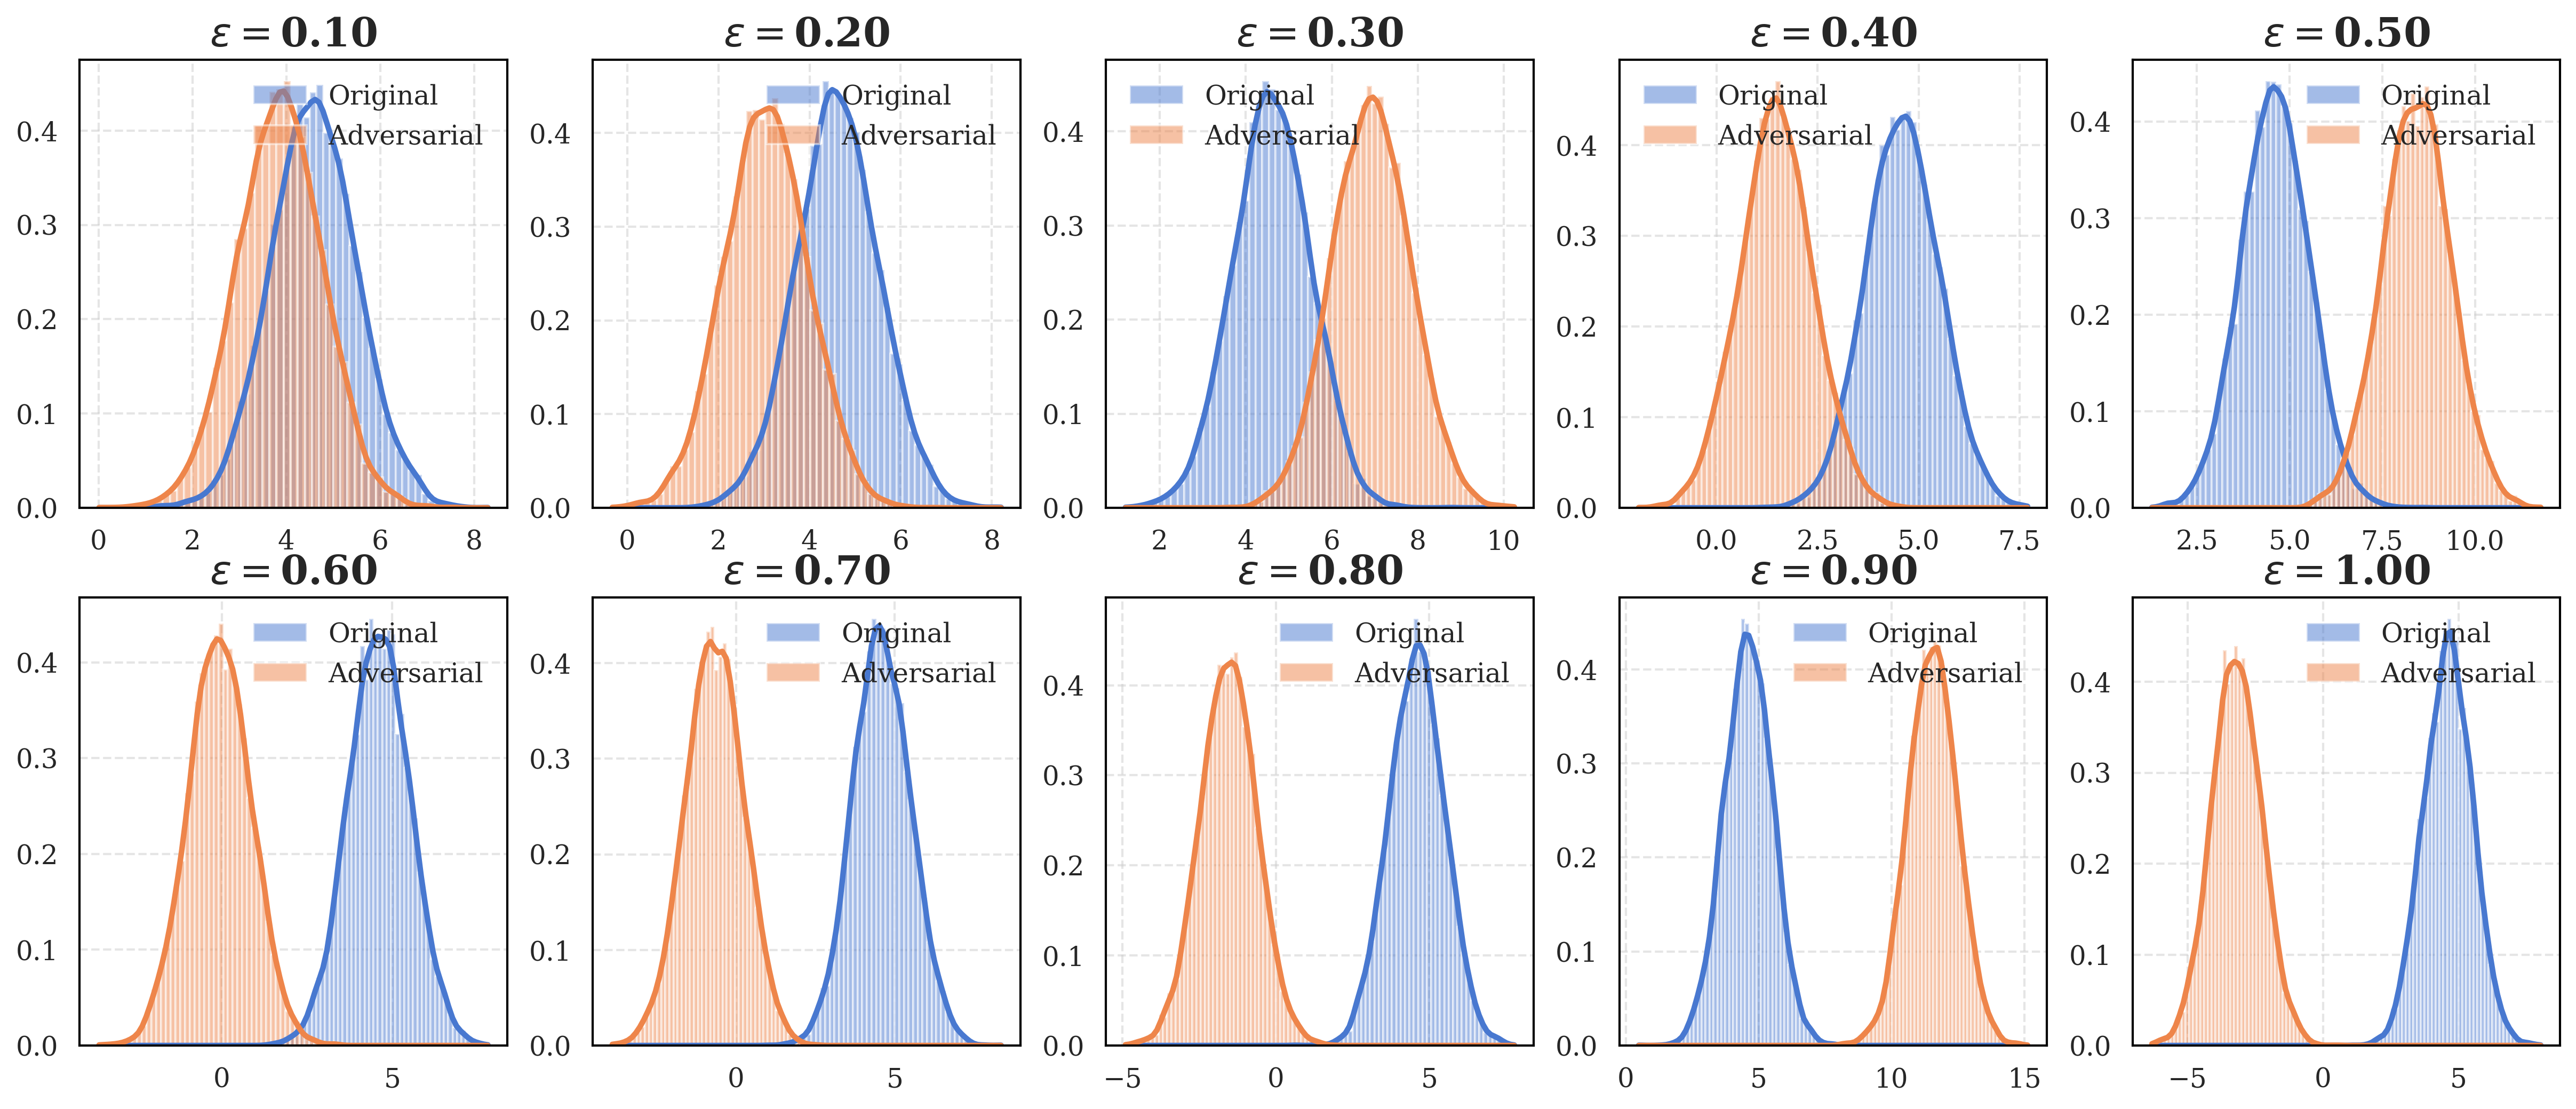

In [24]:
# Plot the histogram for 10 different epsilon values as subplots
epsilons = np.linspace(0.1, 1, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, epsilon in enumerate(epsilons):
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon)
    ax = axs[i // 5, i % 5]

    y_samples = model.sample_predictive_distribution(x, num_samples=10000).numpy()
    y_adv_samples = model.sample_predictive_distribution(x_adv_distr, num_samples=10000).numpy()

    kde = gaussian_kde(y_samples.T)
    kde_adv = gaussian_kde(y_adv_samples.T)

    ax.hist(y_samples, bins=50, alpha=0.5, label='Original', density=True)
    ax.hist(y_adv_samples, bins=50, alpha=0.5, label='Adversarial', density=True)

    ys = np.linspace(
        min(np.min(y_samples), np.min(y_adv_samples)), 
        max(np.max(y_samples), np.max(y_adv_samples)), 
        100)
    # plot with same color and label
    ax.plot(ys, kde(ys), color='C0')
    ax.plot(ys, kde_adv(ys), color='C1')
    ax.legend()

    ax.set_title(f'$\epsilon=${epsilon:.2f}')

### Known variance model

In [25]:
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [26]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
lr = 0.0
mu_n = model.mu
lam_n = model.lam
sigma2 = model.sigma2
x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
optimizer = SGD([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
kl.backward()
real_grad = x_adv.grad.clone().detach()

(array([128., 122., 120., 120., 110.,  92.,  71.,  42.,  42.,  43.,  23.,
         27.,  17.,  17.,  11.,   1.,   7.,   1.,   4.,   2.]),
 array([9.64227412e-03, 1.50667517e+00, 3.00370807e+00, 4.50074097e+00,
        5.99777386e+00, 7.49480676e+00, 8.99183966e+00, 1.04888726e+01,
        1.19859055e+01, 1.34829383e+01, 1.49799712e+01, 1.64770041e+01,
        1.79740370e+01, 1.94710699e+01, 2.09681028e+01, 2.24651357e+01,
        2.39621686e+01, 2.54592015e+01, 2.69562344e+01, 2.84532673e+01,
        2.99503002e+01]),
 <BarContainer object of 20 artists>)

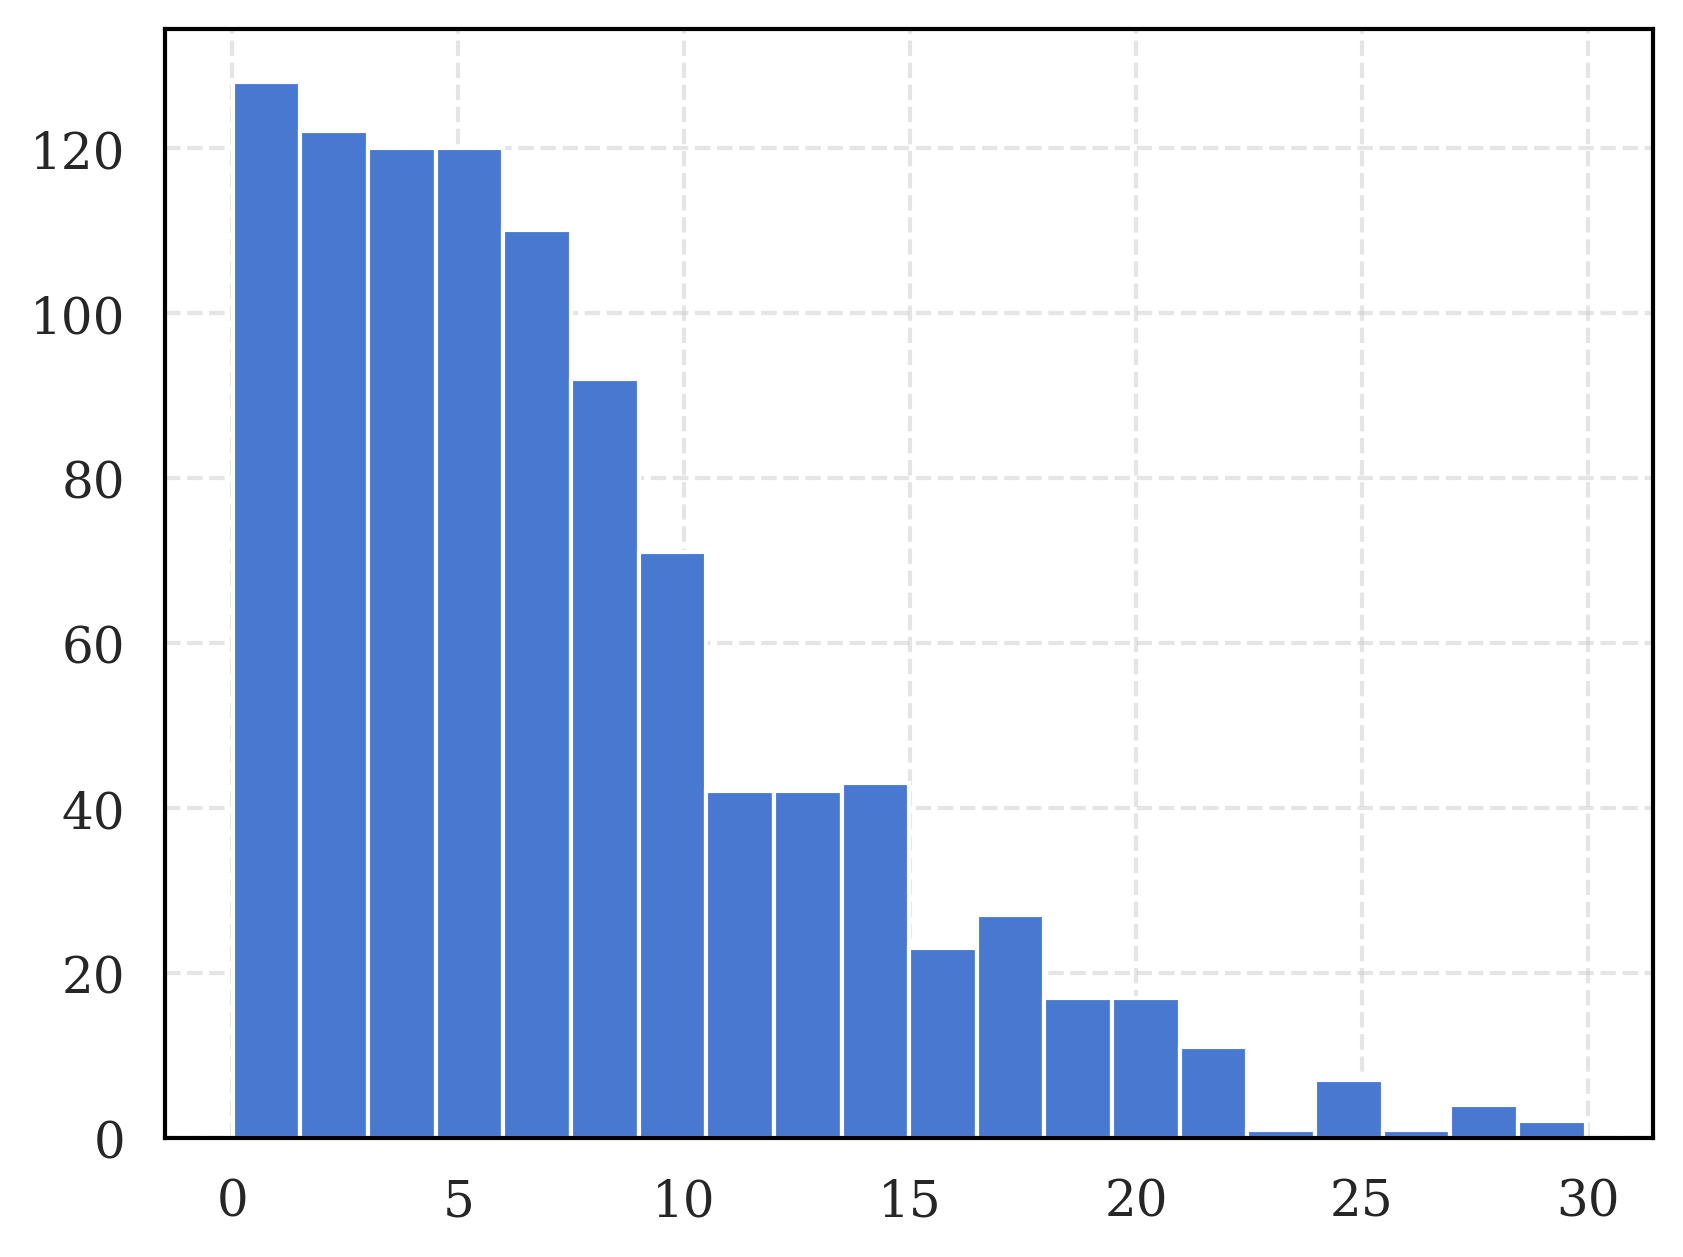

In [27]:
norms = []
for it in range(1000):
    y = model.sample_predictive_distribution(x, num_samples=1)
    gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1)
    norms.append(torch.norm(real_grad - gradient_estimate).detach().item())
        
plt.hist(norms, bins=20)

In [ ]:
# same as before but estimate the gradient doing the mean of 1000 iterations and doing it in paralell with joblib
def compute_norms(it):
    y = model.sample_predictive_distribution(x, num_samples=1)
    gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1).clone().detach()
    for _ in range(100):
        y = model.sample_predictive_distribution(x, num_samples=1)
        gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1).clone().detach()
        gradient_estimate += gradient_estimate
    gradient_estimate /= 101
    return torch.norm(real_grad - gradient_estimate).detach().item()

n_jobs = 66
norms = Parallel(n_jobs=n_jobs)(delayed(compute_norms)(i) for i in range(1000))
plt.hist(norms, bins=20)

# Comparison of 3 datasets: Wine, energy and housing

In [4]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
data = pd.read_excel(url)

# The last two columns are the target variables (Heating Load and Cooling Load)
X = data.iloc[:, :-2].values  # Covariates
y = data.iloc[:, -2].values  # Heating Load
y_energy = y / 4  # to make the target variable similar to the other datasets

# Normalize the data
scaler = MinMaxScaler()
X_energy = scaler.fit_transform(X)

In [5]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y_wine = data.iloc[:, -1].values

# Normalize the data
scaler = MinMaxScaler()
X_wine = scaler.fit_transform(X)

In [6]:
# Housing dataset
california_housing = fetch_california_housing(as_frame=True)

X = california_housing.data.values
y_housing = california_housing.target.values

X_housing = MinMaxScaler().fit_transform(X)

In [10]:
# For all 3 datasets: Fit the model, compute the average rmse over the test set for the original data and the adversarial examples with epsilon = 0.2 and epsilon = 0.5
datasets = ['energy', 'housing', 'wine']
epsilons = [0, 0.2, 0.5]

results = []
results_attack = []

for dataset in datasets:
    print(f'Running dataset {dataset}')
    if dataset == 'energy':
        X, y = X_energy, y_energy
    elif dataset == 'wine':
        X, y = X_wine, y_wine
    elif dataset == 'housing':
        X, y = X_housing, y_housing

    results_dataset = []
    results_dataset_attack = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

        model = NormalInverseGammaPriorLinearRegression(prior_params={
            'mu': torch.zeros(X_train.shape[1]), 
            'lam': torch.eye(X_train.shape[1]), 
            'a': torch.tensor([10]), 
            'b': torch.tensor([1])}
            )
        data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
        model.fit(data)

        X_test = X_test[:88, :]  # 88 is the njobs number, so we can parallelize the computation efficiently
        y_test = y_test[:88]

        res_it = []
        res_it_attack = []
        for epsilon in epsilons:
            def compute_kl(i):
                x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
                std = model.sample_predictive_distribution(x, 1000).std()
                appd = torch.distributions.normal.Normal(2 + x.T @ model.mu, 2 * std)
                if epsilon == 0:
                    x_adv = x.clone().detach()
                else:
                    x_adv, _ = mlmc_attack(model, x, appd, epsilon=epsilon, verbose=False, R=10, lr=0.1, n_iter=800)
                sigma2 = model.sample_posterior_distribution(1000)[1].mean()
                att_kl = kl_to_appd(model.mu, model.lam, sigma2, x_adv, 2 * x.T @ model.mu, 4 * std ** 2).item()
                df_kl = kl_div(model.mu, model.lam, sigma2, x, x_adv).item()
                return df_kl#, df_kl

            kl_values = Parallel(n_jobs=-1)(delayed(compute_kl)(i) for i in range(X_test.shape[0]))
            #kl_values_attack = np.array(kl_values)[]
            kl = sum(kl_values)
            res_it.append(kl / X_test.shape[0])
        results_dataset.append(res_it)
    results.append(results_dataset)

Running dataset energy


Running dataset housing
Running dataset wine


/home/pgarcia/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [11]:
# Display as a table
results_array = np.array(results).mean(axis=1)
results_array = np.round(results_array, 3)
results_df = pd.DataFrame(results_array, columns=epsilons, index=datasets)
results_df

,0.0,0.2,0.5
energy,0.0,0.472,2.984
housing,0.0,2.846,11.348
wine,0.0,1.298,7.545


In [12]:
# Display as a table
results_array = 2 * np.array(results).std(axis=1)
results_array = np.round(results_array, 3)
results_df = pd.DataFrame(results_array, columns=epsilons, index=datasets)
results_df

,0.0,0.2,0.5
energy,0.0,0.043,0.338
housing,0.0,0.334,1.441
wine,0.0,0.118,0.433
